# Financial Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
import itertools
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import numpy as np
from arch import arch_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

## Data Cleaning

In [2]:
# Load the dataset
df = pd.read_csv("DJIA_2004_2023.csv", parse_dates=['Date'])
# Convert the 'Date' column to datetime while accounting for time zones, then extract the date part
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.date
# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

In [3]:
# Display the first rows
df.head()

AAPL   AMGN    AXP     BA    CAT   CSCO    CVX    DIS     GS  \
Date                                                                       
2004-01-02  0.32  44.82  31.08  28.91  24.73  16.58  20.19  18.99  71.98   
2004-01-05  0.34  44.82  31.35  28.97  25.40  16.93  20.58  19.36  72.01   
2004-01-06  0.33  44.97  31.41  28.87  24.95  17.13  20.47  19.41  71.58   
2004-01-07  0.34  45.56  31.50  29.11  24.68  17.48  20.21  19.73  73.09   
2004-01-08  0.35  45.55  31.41  29.51  24.49  18.01  20.23  20.02  73.18   

               HD  ...    MMM    MRK   MSFT   NKE     PG    TRV    UNH     VZ  \
Date               ...                                                          
2004-01-02  21.76  ...  46.18  21.66  17.14  6.66  28.42  24.17  23.77  11.78   
2004-01-05  21.76  ...  47.06  22.09  17.57  6.66  28.56  24.23  22.63  12.12   
2004-01-06  22.00  ...  46.91  21.99  17.63  6.65  28.42  24.04  22.86  12.32   
2004-01-07  22.30  ...  46.10  22.01  17.61  6.67  28.16  24.04  23.07  12.35   
2004-01-08  22.12  ...  45.79  22.13  17.58  6.74  28.46  24.20  23.12  12.54   

              WBA    WMT  
Date                      
2004-01-02  22.02  11.62  
2004-01-05  21.74  11.58  
2004-01-06  21.60  11.85  
2004-01-07  21.24  11.88  
2004-01-08  21.26  11.84  

[5 rows x 27 columns]

In [4]:
# Check for missing values in these columns
missing_values = df.isnull().sum()

# Display missing values information
missing_values

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
VZ      0
WBA     0
WMT     0
dtype: int64

Since there are no missing values we can proceed with analysis.

## Time Series Analysis

In [5]:
# Extract the stock price columns
selected_stocks = df[['KO', 'PG', 'MSFT', 'WMT', 'JPM']].copy()

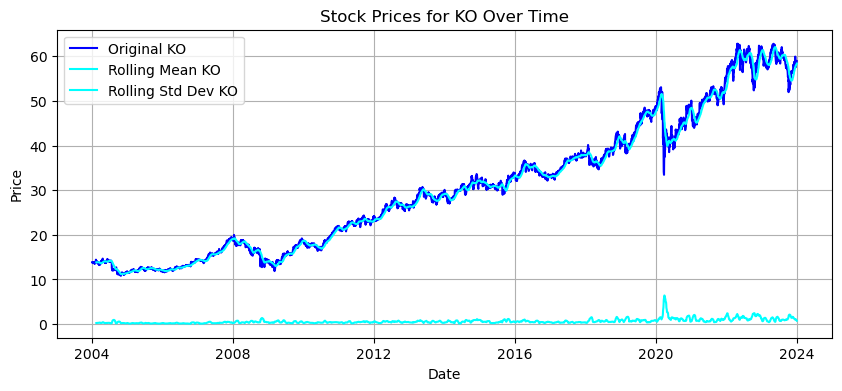

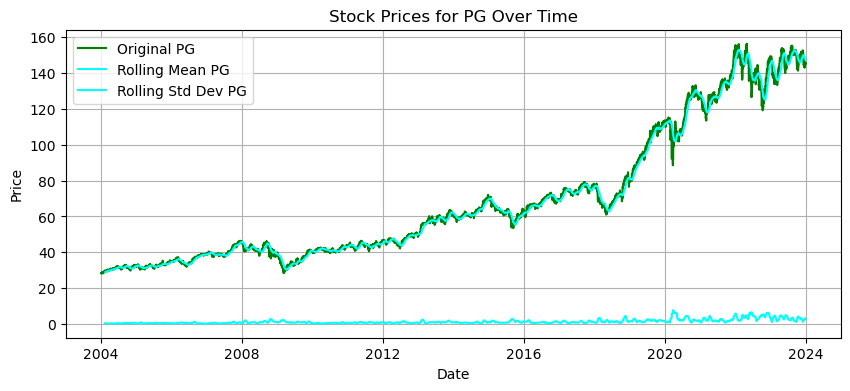

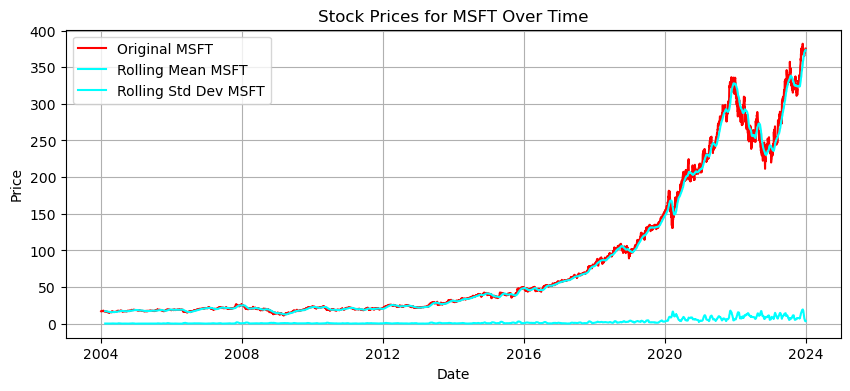

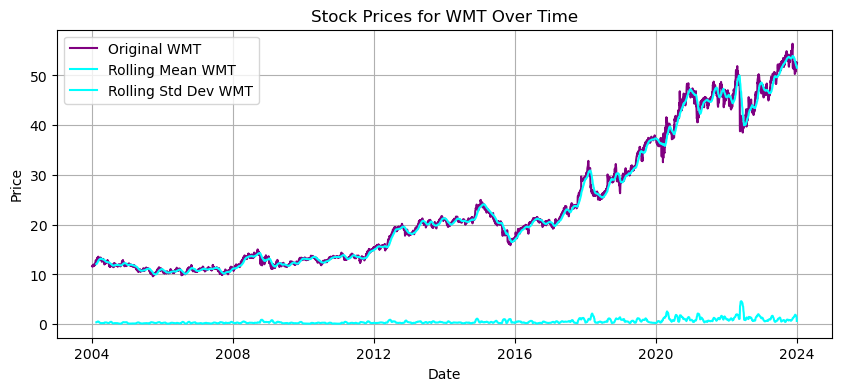

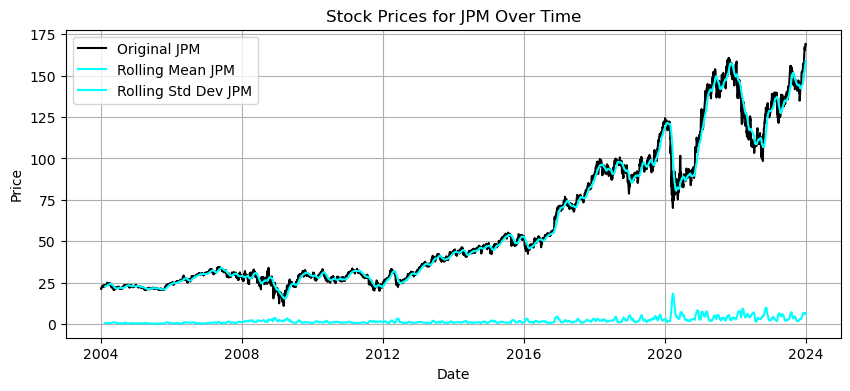

In [6]:
# List of stock labels and corresponding colors for plotting
stock_labels = ['KO', 'PG', 'MSFT', 'WMT', 'JPM']
colors = ['blue', 'green', 'red', 'purple', 'black']

# Calculate and plot rolling mean and standard deviation for each stock
for stock, color in zip(stock_labels, colors):
    # Calculate rolling mean and standard deviation
    rolling_mean = selected_stocks[stock].rolling(window=30).mean()
    rolling_std = selected_stocks[stock].rolling(window=30).std()
    # Plot the original stock prices, rolling mean, and rolling standard deviation
    plt.figure(figsize=(10, 4))
    plt.plot(selected_stocks[stock], label=f'Original {stock}', color=color)
    plt.plot(rolling_mean, label=f'Rolling Mean {stock}', color='cyan')
    plt.plot(rolling_std, label=f'Rolling Std Dev {stock}', color='cyan')
    
    plt.title(f'Stock Prices for {stock} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

Overall Insights:

Growth Trends: Microsoft and Procter & Gamble show the strongest growth trends among the selected stocks. Microsoft, in particular, stands out due to its exponential growth reflecting the overall boom in technology.

Stability vs. Volatility: Coca-Cola and Walmart demonstrate stability, making them potentially less risky investments. In contrast, Microsoft and JPMorgan exhibit higher volatility, offering potentially higher returns but at greater risk.

Sector Influence: The behavior of these stocks also reflects their sector characteristics. Consumer staples (KO, PG) are more stable, tech stocks (MSFT) are rapidly growing and volatile, while financials (JPM) show susceptibility to economic cycles.


In [7]:
# Calculate daily returns for each stock
for stock in selected_stocks.columns:
    selected_stocks.loc[:, f'{stock}_returns'] = selected_stocks.loc[:, stock].pct_change()*100

# Drop rows with any missing values to ensure dataset completeness
selected_stocks.dropna(inplace=True)

# Display the head of the DataFrame to confirm the changes
print(selected_stocks.head())

               KO     PG   MSFT    WMT    JPM  KO_returns  PG_returns  \
Date                                                                    
2004-01-05  13.87  28.56  17.57  11.58  21.16    0.072150    0.492611   
2004-01-06  13.82  28.42  17.63  11.85  21.69   -0.360490   -0.490196   
2004-01-07  13.73  28.16  17.61  11.88  22.01   -0.651230   -0.914849   
2004-01-08  13.80  28.46  17.58  11.84  22.38    0.509832    1.065341   
2004-01-09  13.65  28.61  17.27  11.64  22.44   -1.086957    0.527056   

            MSFT_returns  WMT_returns  JPM_returns  
Date                                                
2004-01-05      2.508751    -0.344234    -0.188679  
2004-01-06      0.341491     2.331606     2.504726  
2004-01-07     -0.113443     0.253165     1.475334  
2004-01-08     -0.170358    -0.336700     1.681054  
2004-01-09     -1.763367    -1.689189     0.268097  


In [8]:

selected_stocks.describe()

KO           PG         MSFT          WMT          JPM  \
count  5032.000000  5032.000000  5032.000000  5032.000000  5032.000000   
mean     30.399630    68.936500    82.478070    23.134791    59.849298   
std      14.765911    36.861472    95.337324    12.836423    41.028245   
min      10.810000    28.160000    11.280000     9.620000    10.950000   
25%      16.937500    40.457500    20.120000    12.607500    27.547500   
50%      29.130000    59.265000    31.235000    19.650000    42.160000   
75%      39.652500    81.445000   104.082500    30.132500    91.065000   
max      62.820000   156.230000   381.990000    56.380000   169.260000   

        KO_returns   PG_returns  MSFT_returns  WMT_returns  JPM_returns  
count  5032.000000  5032.000000   5032.000000  5032.000000  5032.000000  
mean      0.035423     0.038917      0.075819     0.037933     0.067007  
std       1.153600     1.135435      1.702730     1.260744     2.280212  
min      -9.678819    -8.738248    -14.739866   -11.373524   -20.687460  
25%      -0.491846    -0.486160     -0.721407    -0.580311    -0.807676  
50%       0.054098     0.042413      0.047943     0.050404     0.031293  
75%       0.578727     0.590079      0.882583     0.642338     0.903000  
max      13.875969    12.014747     18.607595    11.703083    25.040128

General Observations

Count: Each stock has 5,033 data points, indicating a complete dataset for the 20-year period with daily trading data.

Mean:

KO (Coca-Cola) and WMT (Walmart) have relatively lower mean prices compared to the other selected stocks. Coca-Cola has a mean price of around 30.40, while Walmart's mean price is about 23.13.

PG (Procter & Gamble), MSFT (Microsoft), and JPM (JPMorgan Chase) exhibit higher mean prices, highlighting their higher stock values over the period. Microsoft, in particular, shows a significantly higher mean price of $82.47, reflective of its growth, especially in the tech sector.

Standard Deviation:

MSFT shows the highest standard deviation of 95.33, indicating a higher volatility and range of trading prices throughout the period. This is consistent with the technology sector's rapid growth and occasional sharp market corrections.

KO, WMT, and PG display lower volatility, which is typical for consumer goods companies that tend to have more stable market performances.

Minimum and Maximum:

The minimum and maximum values show the range of prices throughout the period. MSFT stands out with the maximum price reaching up to $381.99, underscoring its substantial price increase, likely driven by strong business growth and market conditions favorable to the tech industry.

JPM also shows a substantial range, with prices moving from 10.95 to 169.26, highlighting significant growth in the financial sector.

In [9]:
# Function to perform Augmented Dickey-Fuller (ADF) test
def adf_tests(stock_data, stock_labels):
    results = []
    for stock in stock_labels:
        adf_test = adfuller(stock_data[stock])
        results.append({
            "Stock": stock,
            "ADF Statistic": adf_test[0],
            "p-value": adf_test[1],
            "Used Lag": adf_test[2],
            "Number of Observations": adf_test[3],
            "Critical Value (1%)": adf_test[4]['1%'],
            "Critical Value (5%)": adf_test[4]['5%'],
            "Critical Value (10%)": adf_test[4]['10%']
        })

    return pd.DataFrame(results)

In [10]:
# Perform ADF test on stock prices to check for stationarity
adf_tests(selected_stocks, ['KO', 'PG', 'MSFT', 'WMT', 'JPM'])

Stock  ADF Statistic   p-value  Used Lag  Number of Observations  \
0    KO       0.120544  0.967436        29                    5002   
1    PG       0.146746  0.969111        18                    5013   
2  MSFT       3.052367  1.000000        32                    4999   
3   WMT       0.999572  0.994261        31                    5000   
4   JPM       0.682626  0.989485        28                    5003   

   Critical Value (1%)  Critical Value (5%)  Critical Value (10%)  
0            -3.431658            -2.862118             -2.567078  
1            -3.431655            -2.862117             -2.567077  
2            -3.431659            -2.862118             -2.567078  
3            -3.431659            -2.862118             -2.567078  
4            -3.431658            -2.862118             -2.567078

All the selected stock time series are non-stationary based on their ADF test results and p-values, indicating that we fail to reject the null hypothesis. Non-stationarity implies that the mean, variance, or covariance of the series may change over time, which can affect the accuracy and stability of a predictive model.

In [11]:
# Perform ADF test on stock returns to check for stationarity
adf_tests(selected_stocks, ['KO_returns', 'PG_returns', 'MSFT_returns', 'WMT_returns', 'JPM_returns'])

Stock  ADF Statistic       p-value  Used Lag  \
0    KO_returns     -30.960802  0.000000e+00         5   
1    PG_returns     -23.535756  0.000000e+00         8   
2  MSFT_returns     -25.734172  0.000000e+00         8   
3   WMT_returns     -16.300752  3.268141e-29        21   
4   JPM_returns     -12.174532  1.396040e-22        32   

   Number of Observations  Critical Value (1%)  Critical Value (5%)  \
0                    5026            -3.431652            -2.862115   
1                    5023            -3.431653            -2.862116   
2                    5023            -3.431653            -2.862116   
3                    5010            -3.431656            -2.862117   
4                    4999            -3.431659            -2.862118   

   Critical Value (10%)  
0             -2.567076  
1             -2.567076  
2             -2.567076  
3             -2.567077  
4             -2.567078

All the return series for KO, PG, MSFT, WMT, and JPM demonstrate stationarity. This means that the mean, variance, and autocorrelation structure of the series do not change over time, making these series suitable for further time series analysis and forecasting models that assume stationarity.

In [12]:
# Apply first differencing to stock prices to achieve stationarity
differenced_data = selected_stocks[['KO', 'PG', 'MSFT', 'WMT', 'JPM']].diff().dropna()

In [13]:
differenced_data

KO    PG  MSFT   WMT   JPM
Date                                    
2004-01-06 -0.05 -0.14  0.06  0.27  0.53
2004-01-07 -0.09 -0.26 -0.02  0.03  0.32
2004-01-08  0.07  0.30 -0.03 -0.04  0.37
2004-01-09 -0.15  0.15 -0.31 -0.20  0.06
2004-01-12  0.11  0.17 -0.06  0.03  0.01
...          ...   ...   ...   ...   ...
2023-12-22  0.33  1.02  1.04  0.62 -0.10
2023-12-26  0.24  0.65  0.08 -0.08  0.99
2023-12-27  0.15  0.12 -0.59  0.49  1.00
2023-12-28  0.04 -0.32  1.21 -0.11  0.90
2023-12-29  0.18  0.80  0.76  0.03 -0.20

[5031 rows x 5 columns]

In [14]:
adf_tests(differenced_data, ['KO', 'PG', 'MSFT', 'WMT', 'JPM'])

Stock  ADF Statistic       p-value  Used Lag  Number of Observations  \
0    KO     -14.805299  2.069606e-27        28                    5002   
1    PG     -15.906444  8.216804e-29        17                    5013   
2  MSFT     -15.258282  4.900881e-28        22                    5008   
3   WMT     -15.040162  9.619116e-28        30                    5000   
4   JPM     -11.772971  1.078942e-21        32                    4998   

   Critical Value (1%)  Critical Value (5%)  Critical Value (10%)  
0            -3.431658            -2.862118             -2.567078  
1            -3.431655            -2.862117             -2.567077  
2            -3.431656            -2.862117             -2.567077  
3            -3.431659            -2.862118             -2.567078  
4            -3.431659            -2.862118             -2.567078

The first differencing of the stock prices has effectively transformed all the selected stock time series into stationary series.

In [15]:
# Divide the data into 80% train and 20% test sets
train_data, test_data = train_test_split(selected_stocks, test_size=0.20, shuffle=False)

In [16]:
train_data.describe()

KO           PG         MSFT          WMT          JPM  \
count  4025.000000  4025.000000  4025.000000  4025.000000  4025.000000   
mean     24.722922    52.815379    38.570489    17.545779    43.327876   
std      10.017067    18.676340    30.844995     6.677341    24.710760   
min      10.810000    28.160000    11.280000     9.620000    10.950000   
25%      15.440000    38.630000    19.270000    11.990000    26.130000   
50%      23.590000    45.460000    23.060000    15.120000    31.300000   
75%      32.860000    65.430000    45.940000    20.930000    51.180000   
max      48.850000   113.510000   152.900000    37.960000   122.540000   

        KO_returns   PG_returns  MSFT_returns  WMT_returns  JPM_returns  
count  4025.000000  4025.000000   4025.000000  4025.000000  4025.000000  
mean      0.037095     0.039710      0.066979     0.036187     0.069834  
std       1.080868     1.060531      1.603267     1.197908     2.307970  
min      -8.689749    -7.889075    -11.715481   -10.191083   -20.687460  
25%      -0.476591    -0.462671     -0.682415    -0.569106    -0.770848  
50%       0.051387     0.031437      0.039565     0.050582     0.031172  
75%       0.564744     0.553962      0.803213     0.625489     0.878378  
max      13.875969    10.207991     18.607595    11.082910    25.040128

In [17]:
train_data

KO      PG    MSFT    WMT     JPM  KO_returns  PG_returns  \
Date                                                                       
2004-01-05  13.87   28.56   17.57  11.58   21.16    0.072150    0.492611   
2004-01-06  13.82   28.42   17.63  11.85   21.69   -0.360490   -0.490196   
2004-01-07  13.73   28.16   17.61  11.88   22.01   -0.651230   -0.914849   
2004-01-08  13.80   28.46   17.58  11.84   22.38    0.509832    1.065341   
2004-01-09  13.65   28.61   17.27  11.64   22.44   -1.086957    0.527056   
...           ...     ...     ...    ...     ...         ...         ...   
2019-12-23  48.46  112.44  151.41  37.25  120.83   -0.123660   -0.363314   
2019-12-24  48.29  112.72  151.38  37.40  121.16   -0.350805    0.249022   
2019-12-26  48.56  112.72  152.62  37.40  122.45    0.559122    0.000000   
2019-12-27  48.85  113.51  152.90  37.43  122.54    0.597199    0.700852   
2019-12-30  48.78  112.05  151.58  37.37  122.09   -0.143296   -1.286230   

            MSFT_returns  WMT_returns  JPM_returns  
Date                                                
2004-01-05      2.508751    -0.344234    -0.188679  
2004-01-06      0.341491     2.331606     2.504726  
2004-01-07     -0.113443     0.253165     1.475334  
2004-01-08     -0.170358    -0.336700     1.681054  
2004-01-09     -1.763367    -1.689189     0.268097  
...                  ...          ...          ...  
2019-12-23      0.000000    -1.062417    -0.024822  
2019-12-24     -0.019814     0.402685     0.273111  
2019-12-26      0.819131     0.000000     1.064708  
2019-12-27      0.183462     0.080214     0.073499  
2019-12-30     -0.863309    -0.160299    -0.367227  

[4025 rows x 10 columns]

In [18]:
test_data

KO      PG    MSFT    WMT     JPM  KO_returns  PG_returns  \
Date                                                                       
2019-12-31  48.85  112.44  151.69  37.19  122.77    0.143501    0.348059   
2020-01-02  48.53  111.09  154.49  37.22  124.25   -0.655067   -1.200640   
2020-01-03  48.27  110.35  152.57  36.89  122.61   -0.535751   -0.666127   
2020-01-06  48.25  110.50  152.96  36.82  122.52   -0.041434    0.135931   
2020-01-07  47.88  109.82  151.57  36.48  120.43   -0.766839   -0.615385   
...           ...     ...     ...    ...     ...         ...         ...   
2023-12-22  58.32  144.37  373.89  52.22  166.37    0.569064    0.711545   
2023-12-26  58.56  145.02  373.97  52.14  167.36    0.411523    0.450232   
2023-12-27  58.71  145.14  373.38  52.63  168.36    0.256148    0.082747   
2023-12-28  58.75  144.82  374.59  52.52  169.26    0.068131   -0.220477   
2023-12-29  58.93  145.62  375.35  52.55  169.06    0.306383    0.552410   

            MSFT_returns  WMT_returns  JPM_returns  
Date                                                
2019-12-31      0.072569    -0.481670     0.556966  
2020-01-02      1.845870     0.080667     1.205506  
2020-01-03     -1.242799    -0.886620    -1.319920  
2020-01-06      0.255620    -0.189753    -0.073403  
2020-01-07     -0.908734    -0.923411    -1.705844  
...                  ...          ...          ...  
2023-12-22      0.278933     1.201550    -0.060071  
2023-12-26      0.021397    -0.153198     0.595059  
2023-12-27     -0.157767     0.939778     0.597514  
2023-12-28      0.324067    -0.209006     0.534569  
2023-12-29      0.202888     0.057121    -0.118161  

[1007 rows x 10 columns]

Fitting auto ARIMA for KO
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=552.539, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=571.158, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=568.891, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=568.315, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=573.648, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=557.590, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=558.322, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=550.411, Time=2.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=560.329, Time=0.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=552.406, Time=4.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=548.193, Time=3.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=550.405, Time=3.63 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=555.791, Time=2.41 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=554.294, Time=3.79 sec
 ARIMA(2,1,4)(0,0,0)[

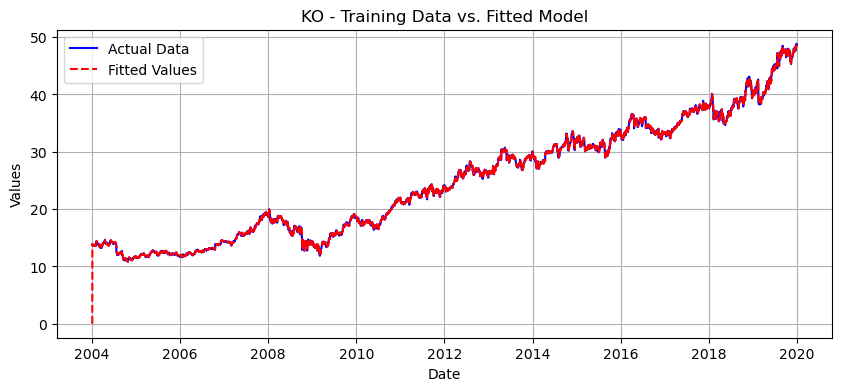

Best model for KO:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4025
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -266.096
Date:                Sun, 19 May 2024   AIC                            548.193
Time:                        15:14:05   BIC                            598.593
Sample:                             0   HQIC                           566.053
                               - 4025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.001      2.566      0.010       0.001       0.007
ar.L1         -0.7505      0.074    -10.202      0.000      -0.895      -0.606
ar.L2          0.5366      0.057 

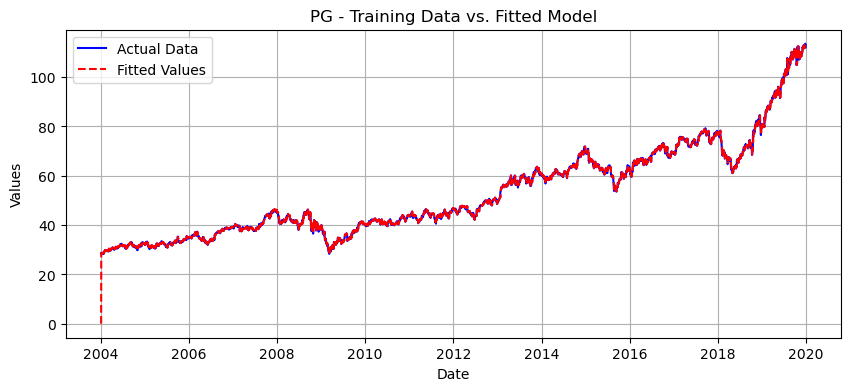

Best model for PG:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4025
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -3395.430
Date:                Sun, 19 May 2024   AIC                           6802.861
Time:                        15:14:18   BIC                           6840.661
Sample:                             0   HQIC                          6816.256
                               - 4025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0245      0.009      2.751      0.006       0.007       0.042
ar.L1         -0.0603      0.011     -5.485      0.000      -0.082      -0.039
ar.L2         -0.0570      0.010 

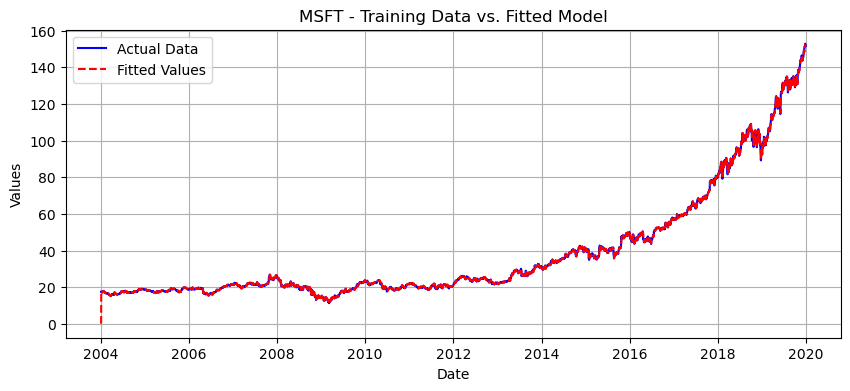

Best model for MSFT:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4025
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -4180.890
Date:                Sun, 19 May 2024   AIC                           8385.781
Time:                        15:15:00   BIC                           8461.381
Sample:                             0   HQIC                          8412.571
                               - 4025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0169      0.006      2.946      0.003       0.006       0.028
ar.L1          0.1861      0.078      2.393      0.017       0.034       0.339
ar.L2          0.3549      0.06

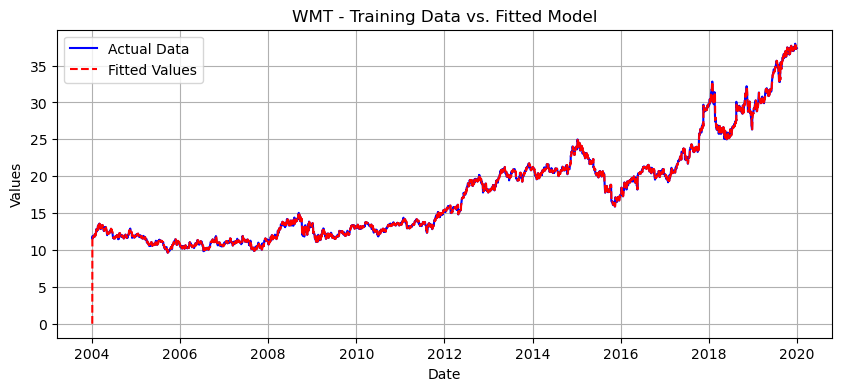

Best model for WMT:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4025
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 425.048
Date:                Sun, 19 May 2024   AIC                           -842.097
Time:                        15:15:06   BIC                           -816.897
Sample:                             0   HQIC                          -833.167
                               - 4025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0064      0.003      2.029      0.042       0.000       0.013
ma.L1         -0.0567      0.009     -6.083      0.000      -0.075      -0.038
ma.L2         -0.0352      0.011

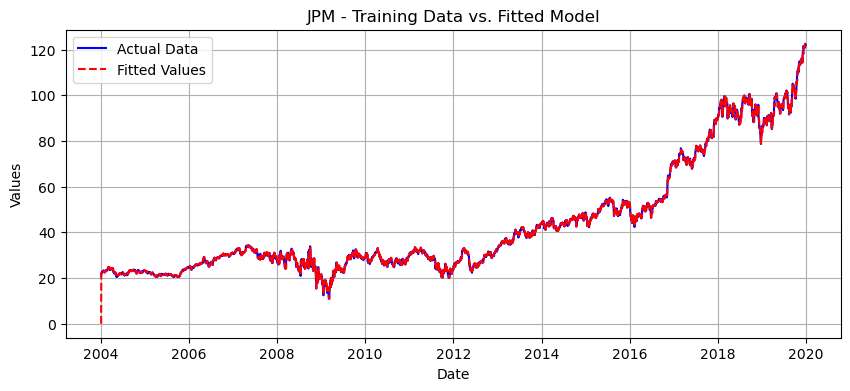

Best model for JPM:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4025
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -4591.939
Date:                Sun, 19 May 2024   AIC                           9189.878
Time:                        15:15:10   BIC                           9208.778
Sample:                             0   HQIC                          9196.576
                               - 4025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0251      0.011      2.229      0.026       0.003       0.047
ma.L1         -0.0590      0.009     -6.699      0.000      -0.076      -0.042
sigma2         0.5737      0.007

In [19]:
# Perform automatic ARIMA model selection for each stock using AIC
stocks = ['KO', 'PG', 'MSFT', 'WMT', 'JPM']
auto_arima_models = {}

for stock in stocks:
    print(f"Fitting auto ARIMA for {stock}")
    model = auto_arima(train_data[stock], max_d=1, maxiter=100, trace=True,
                       stepwise=True)
    auto_arima_models[stock] = model
    # Plotting the fitted model against the actual data
    plt.figure(figsize=(10, 4))
    plt.plot(train_data.index, train_data[stock], label='Actual Data', color='blue')
    # Get in-sample predictions
    in_sample_preds = model.predict_in_sample()
    plt.plot(train_data.index, in_sample_preds, label='Fitted Values', color='red', linestyle='--')
    plt.title(f'{stock} - Training Data vs. Fitted Model')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Print the summary of the fitted model
    print(f"Best model for {stock}: {model.summary()}\n")

Validating model for KO


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


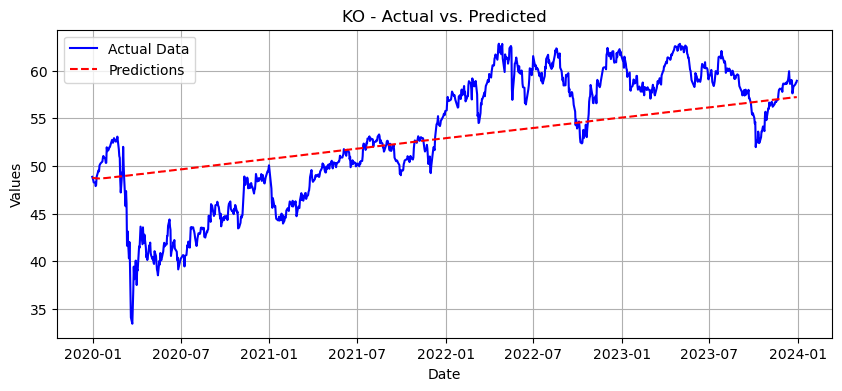

Performance metrics for KO:
MAE: 3.9853452234141113
RMSE: 4.780821790052585
MAPE: 7.861734429972627%

Validating model for PG


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


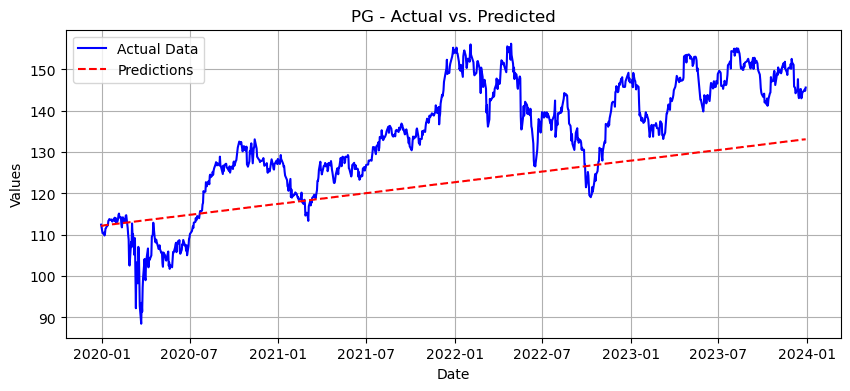

Performance metrics for PG:
MAE: 12.573175843223606
RMSE: 14.612186554131641
MAPE: 9.093537548358748%

Validating model for MSFT


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


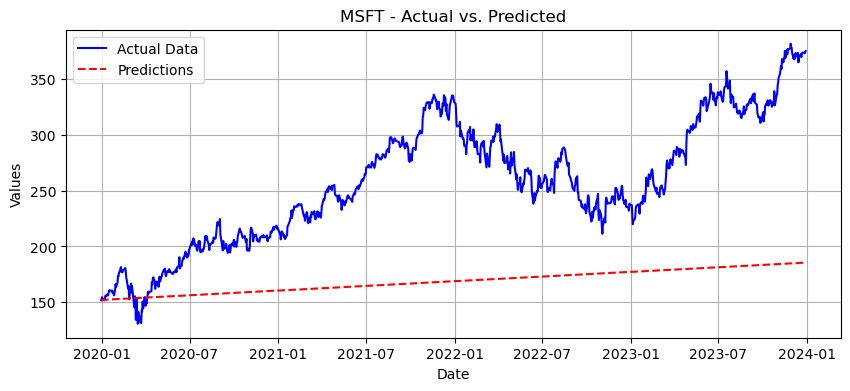

Performance metrics for MSFT:
MAE: 89.6622116826642
RMSE: 101.45706144548153
MAPE: 32.21388333062929%

Validating model for WMT


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


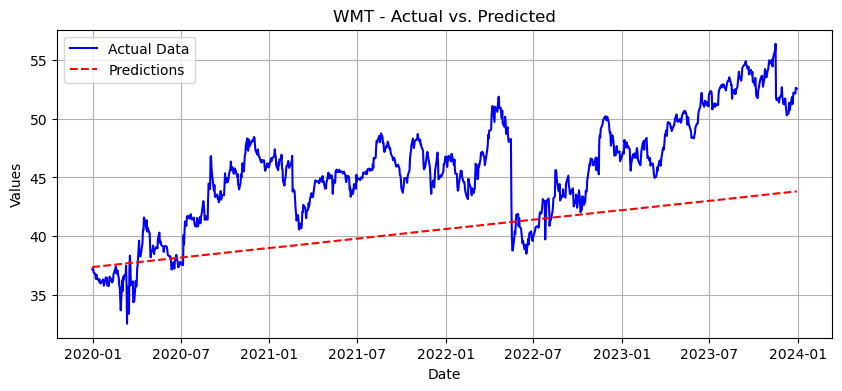

Performance metrics for WMT:
MAE: 5.175370413384557
RMSE: 5.929754108900874
MAPE: 10.908644694999767%

Validating model for JPM


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


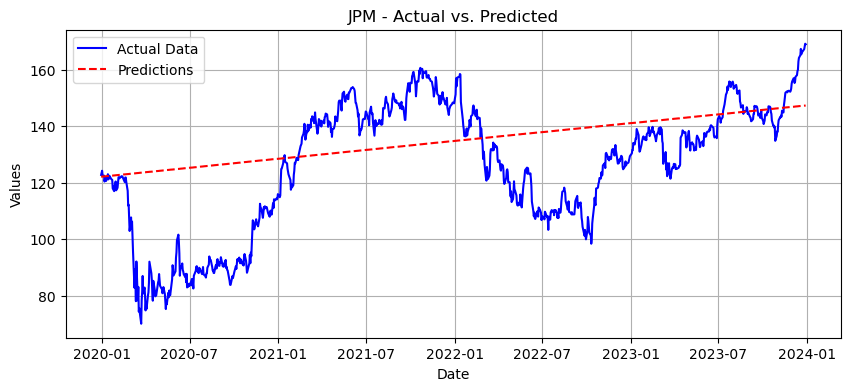

Performance metrics for JPM:
MAE: 17.41461788893023
RMSE: 21.4811908097084
MAPE: 16.144757773999196%

Model performance summary:
KO - MAE: 3.9853452234141113, RMSE: 4.780821790052585, MAPE: 7.861734429972627%
PG - MAE: 12.573175843223606, RMSE: 14.612186554131641, MAPE: 9.093537548358748%
MSFT - MAE: 89.6622116826642, RMSE: 101.45706144548153, MAPE: 32.21388333062929%
WMT - MAE: 5.175370413384557, RMSE: 5.929754108900874, MAPE: 10.908644694999767%
JPM - MAE: 17.41461788893023, RMSE: 21.4811908097084, MAPE: 16.144757773999196%


In [20]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-4  # Increased epsilon value for better handling of near-zero divisions
    y_true_adjusted = np.where(np.abs(y_true) < epsilon, epsilon, y_true)  # Adjust all zero or very small values
    return np.mean(np.abs((y_true_adjusted - y_pred) / y_true_adjusted)) * 100


# Container for error metrics
model_performance = {}

# Validate each ARIMA model
for stock in stocks:
    print(f"Validating model for {stock}")
    # Get the predictions
    predictions = auto_arima_models[stock].predict(n_periods=len(test_data))
    true_values = test_data[stock].values
    
    # Calculate error metrics
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mape = mean_absolute_percentage_error(true_values, predictions)
    
    # Store performance
    model_performance[stock] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }
    
    # Plot predictions vs true values
    plt.figure(figsize=(10, 4))
    plt.plot(test_data.index, true_values, label='Actual Data', color='blue')
    plt.plot(test_data.index, predictions, label='Predictions', color='red', linestyle='--')
    plt.title(f'{stock} - Actual vs. Predicted')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Output the performance
    print(f"Performance metrics for {stock}:\nMAE: {mae}\nRMSE: {rmse}\nMAPE: {mape}%\n")

# print all performance metrics at once
print("Model performance summary:")
for stock, metrics in model_performance.items():
    print(f"{stock} - MAE: {metrics['MAE']}, RMSE: {metrics['RMSE']}, MAPE: {metrics['MAPE']}%")

Performance Analysis

Coca-Cola (KO)

MAE: 3.98, RMSE: 4.78, MAPE: 7.86%

This model shows relatively low error metrics, suggesting a good fit and accurate predictions. The MAPE below 10% is particularly impressive for financial time series data.

Procter & Gamble (PG)

MAE: 12.57, RMSE: 14.61, MAPE: 9.09%

Similar to KO, the errors are moderate, and the MAPE under 10% indicates that the model is quite effective in capturing the dynamics of PG's stock prices.

Microsoft (MSFT)

MAE: 89.66, RMSE: 101.457, MAPE: 32.21%

Interpretation: The errors are significantly higher compared to other stocks. The high MAPE indicates that the model might be insufficient to capture some dynamics or patterns, potentially due to the volatile nature of tech stocks.

Walmart (WMT)

MAE: 5.17, RMSE:5.92, MAPE: 10.90%

Although the errors are low, the MAPE exceeding 10% could be a sign of some model inefficiencies, though it's still a reasonable fit.
JPMorgan Chase (JPM)

MAE: 17.41, RMSE: 21.48, MAPE: 16.14%

The errors and MAPE are moderately high, indicating room for improvement in the model. Financial stocks often exhibit complex patterns that may require a more nuanced modeling approach.

In [21]:

stocks = ['KO', 'PG', 'MSFT', 'WMT', 'JPM']
results = []

# Define the range for p and q you want to test
p_range = range(1, 6)  # GARCH terms
q_range = range(1, 6)  # ARCH terms

# Loop through each stock to access returns from the training dataset
for stock in stocks:
    # Ensure that the stock's returns column exists in the training data
    if f'{stock}_returns' in train_data.columns:
        stock_returns = train_data[f'{stock}_returns']  # Access returns for each stock from the training set

        # Test different combinations of p and q
        for p in p_range:
            for q in q_range:
                model = arch_model(stock_returns, vol='Garch', p=p, q=q)
                fitted_model = model.fit(disp='off', show_warning=False)  # Fit the model silently

                # Append results to the list
                results.append({
                    'Stock': stock,
                    'p': p,
                    'q': q,
                    'AIC': fitted_model.aic,
                    'BIC': fitted_model.bic,
                    'LogLikelihood': fitted_model.loglikelihood
                })

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)

# Finding the best model for each stock based on AIC and BIC
best_models = results_df.loc[results_df.groupby('Stock')['AIC'].idxmin()]
best_models_bic = results_df.loc[results_df.groupby('Stock')['BIC'].idxmin()]

print("\nBest models per stock based on AIC:")
print(best_models[['Stock', 'p', 'q', 'AIC', 'LogLikelihood']])

print("\nBest models per stock based on BIC:")
print(best_models_bic[['Stock', 'p', 'q', 'BIC', 'LogLikelihood']])

    Stock  p  q           AIC           BIC  LogLikelihood
0      KO  1  1  11098.983068  11124.184189   -5545.491534
1      KO  1  2  11099.029482  11130.530883   -5544.514741
2      KO  1  3  11091.512925  11129.314606   -5539.756462
3      KO  1  4  11079.314781  11123.416742   -5532.657390
4      KO  1  5  11079.799474  11130.201715   -5531.899737
..    ... .. ..           ...           ...            ...
120   JPM  5  1  14954.819083  15005.221324   -7469.409541
121   JPM  5  2  14956.439601  15013.142123   -7469.219801
122   JPM  5  3  14949.242470  15012.245272   -7464.621235
123   JPM  5  4  14946.165097  15015.468179   -7462.082549
124   JPM  5  5  14947.371944  15022.975306   -7461.685972

[125 rows x 6 columns]

Best models per stock based on AIC:
    Stock  p  q           AIC  LogLikelihood
108   JPM  2  4  14940.165097   -7462.082548
9      KO  2  5  11071.386446   -5526.693223
59   MSFT  2  5  14335.201254   -7158.600627
38     PG  3  4  11169.433758   -5575.716879
78    

To predict the volatility of stock returns, GARCH models were employed. Different combinations of GARCH(p, q) models were tested, and the best model was selected based on the Bayesian Information Criterion (BIC). The Bayesian Information Criterion (BIC) was chosen as the primary metric for model selection because it provides a balance between model fit and complexity. Lower BIC values indicate models that better explain the data with fewer parameters, reducing the risk of overfitting.

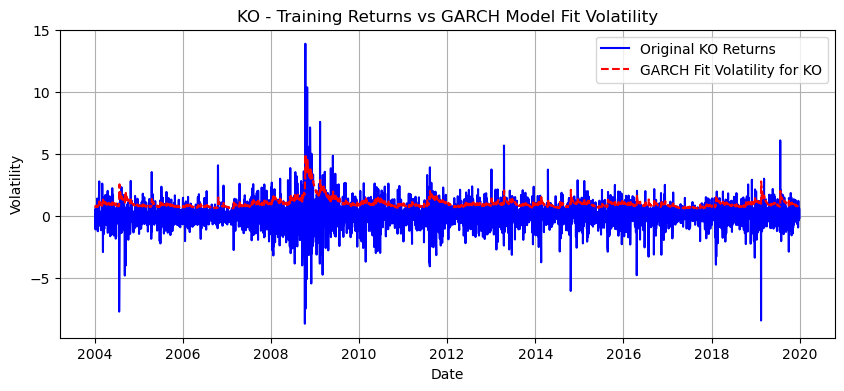

GARCH Model Summary for KO:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             KO_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5532.66
Distribution:                  Normal   AIC:                           11079.3
Method:            Maximum Likelihood   BIC:                           11123.4
                                        No. Observations:                 4025
Date:                Sun, May 19 2024   Df Residuals:                     4024
Time:                        15:15:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0520  1.491e-

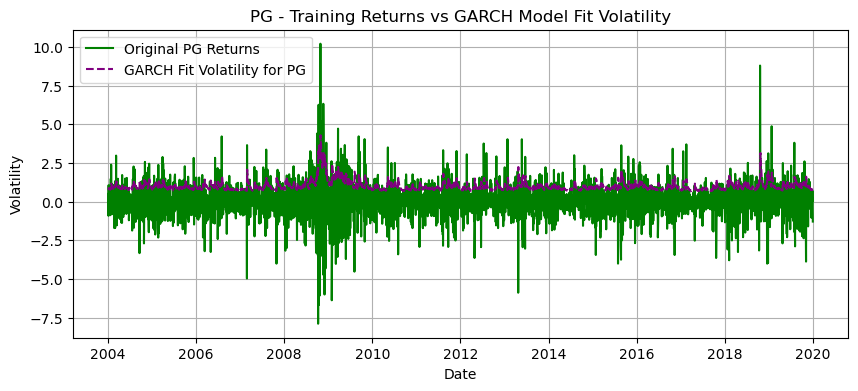

GARCH Model Summary for PG:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             PG_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5580.80
Distribution:                  Normal   AIC:                           11169.6
Method:            Maximum Likelihood   BIC:                           11194.8
                                        No. Observations:                 4025
Date:                Sun, May 19 2024   Df Residuals:                     4024
Time:                        15:15:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0496  1.473e-

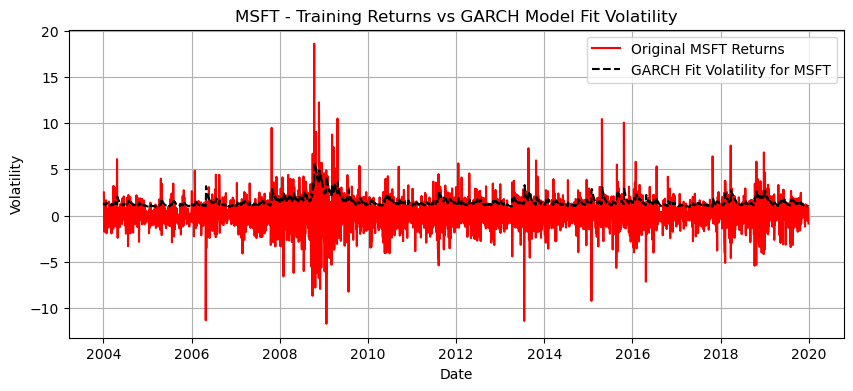

GARCH Model Summary for MSFT:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           MSFT_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7174.37
Distribution:                  Normal   AIC:                           14356.7
Method:            Maximum Likelihood   BIC:                           14381.9
                                        No. Observations:                 4025
Date:                Sun, May 19 2024   Df Residuals:                     4024
Time:                        15:15:15   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0845  2.189e-02  

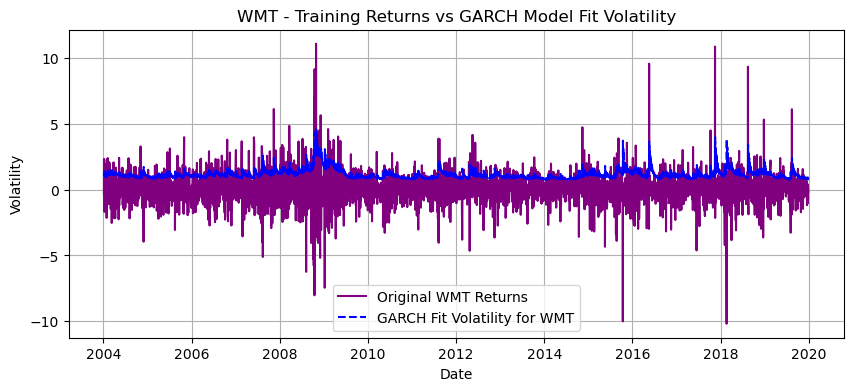

GARCH Model Summary for WMT:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            WMT_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6148.15
Distribution:                  Normal   AIC:                           12308.3
Method:            Maximum Likelihood   BIC:                           12346.1
                                        No. Observations:                 4025
Date:                Sun, May 19 2024   Df Residuals:                     4024
Time:                        15:15:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0404  1.835e

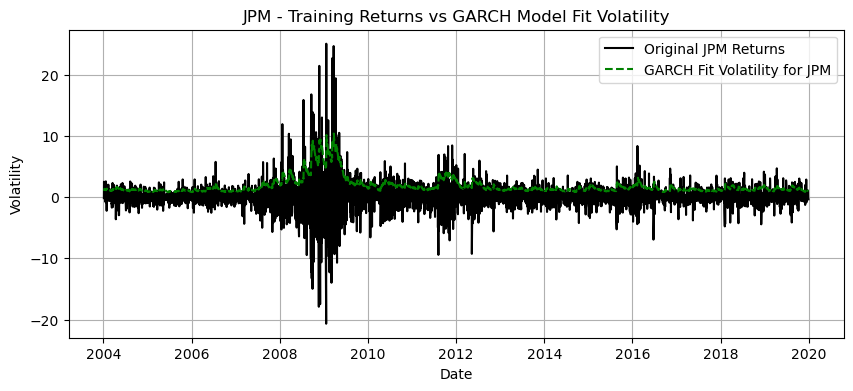

GARCH Model Summary for JPM:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            JPM_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7469.41
Distribution:                  Normal   AIC:                           14946.8
Method:            Maximum Likelihood   BIC:                           14972.0
                                        No. Observations:                 4025
Date:                Sun, May 19 2024   Df Residuals:                     4024
Time:                        15:15:16   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0928  2.144e-02   

In [22]:
# Define the best model parameters for each stock based on previous findings
best_params = {
    'KO': {'p': 1, 'q': 4},
    'PG': {'p': 1, 'q': 1},
    'MSFT': {'p': 1, 'q': 1},
    'WMT': {'p': 1, 'q': 3},
    'JPM': {'p': 1, 'q': 1}
}

stock_labels = ['KO', 'PG', 'MSFT', 'WMT', 'JPM']
colors_train_set = ['blue', 'green', 'red', 'purple', 'black']
colors_fit = ['red', 'purple', 'black', 'blue', 'green']

# Initialize dictionary to store GARCH models
garch_models = {}

# Loop through each stock
for stock, color_train, color_fit in zip(stock_labels, colors_train_set, colors_fit):
    # Retrieve the best parameters for the current stock
    params = best_params[stock]

    # Fit the GARCH model using the best parameters
    best_fit = arch_model(train_data[f'{stock}_returns'], vol='Garch', p=params['p'], q=params['q']).fit(disp='off')

    garch_models[stock] = best_fit

    # Plotting
    plt.figure(figsize=(10, 4))
    # Plot the original return data
    plt.plot(train_data[f'{stock}_returns'].index, train_data[f'{stock}_returns'], label=f'Original {stock} Returns', color=color_train)
    # Plot the conditional volatility from the GARCH model
    plt.plot(train_data[f'{stock}_returns'].index, best_fit.conditional_volatility, label=f'GARCH Fit Volatility for {stock}', color=color_fit, linestyle='--')
    
    plt.title(f'{stock} - Training Returns vs GARCH Model Fit Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the best GARCH model summary
    print(f"GARCH Model Summary for {stock}:\n{best_fit.summary()}\n")

Forecasting and validating volatility for KO


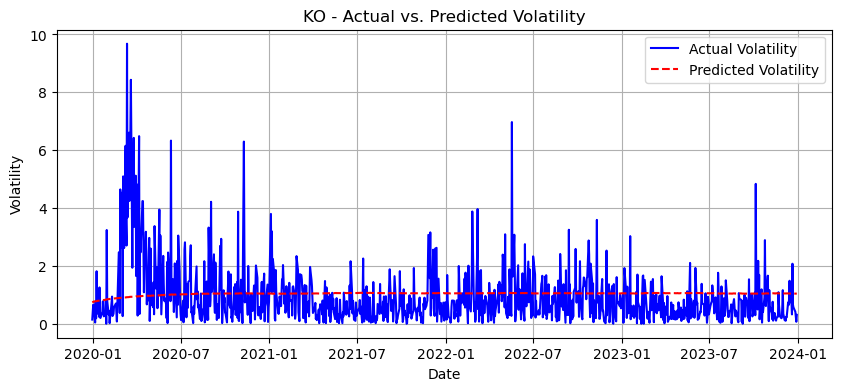

Volatility prediction metrics for KO:
MAE: 0.7323384633348566
RMSE: 1.0784218850778522
MAPE: 6380.000287510286%

Forecasting and validating volatility for PG


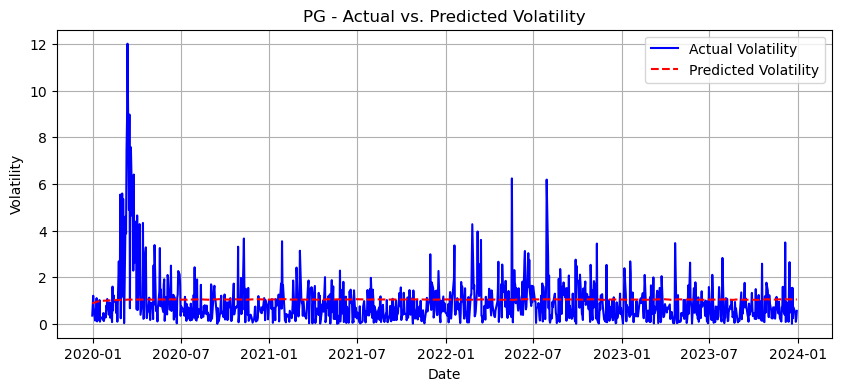

Volatility prediction metrics for PG:
MAE: 0.6953331071254214
RMSE: 1.0659422762740631
MAPE: 4546.38280013211%

Forecasting and validating volatility for MSFT


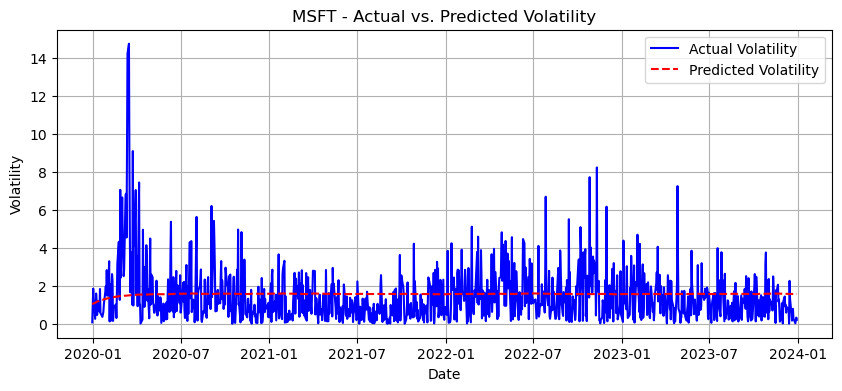

Volatility prediction metrics for MSFT:
MAE: 1.0416092783522397
RMSE: 1.4654813573757646
MAPE: 3676.2275449173194%

Forecasting and validating volatility for WMT


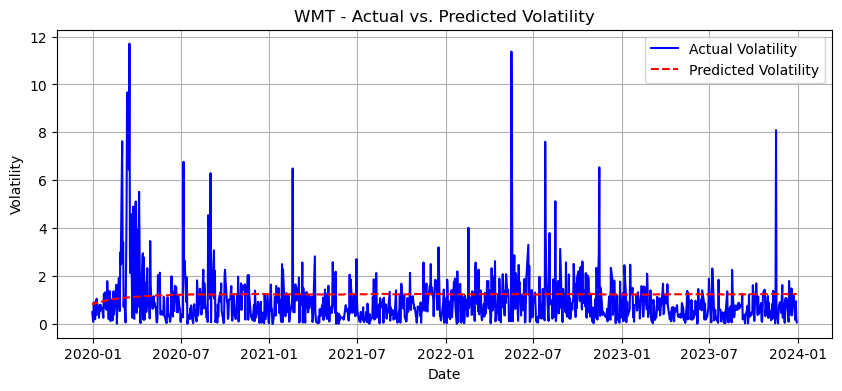

Volatility prediction metrics for WMT:
MAE: 0.7923247322537139
RMSE: 1.175938256712037
MAPE: 11179.387352295866%

Forecasting and validating volatility for JPM


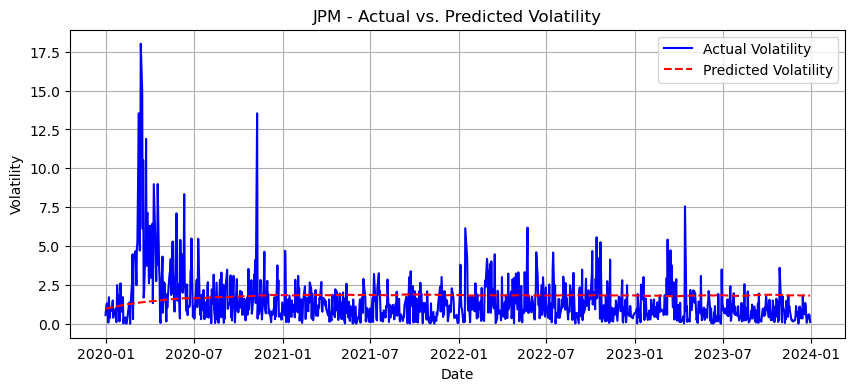

Volatility prediction metrics for JPM:
MAE: 1.1850466552242784
RMSE: 1.7122452260374315
MAPE: 3023.7564312988793%

Volatility model performance summary:
KO - MAE: 0.7323384633348566, RMSE: 1.0784218850778522, MAPE: 6380.000287510286%
PG - MAE: 0.6953331071254214, RMSE: 1.0659422762740631, MAPE: 4546.38280013211%
MSFT - MAE: 1.0416092783522397, RMSE: 1.4654813573757646, MAPE: 3676.2275449173194%
WMT - MAE: 0.7923247322537139, RMSE: 1.175938256712037, MAPE: 11179.387352295866%
JPM - MAE: 1.1850466552242784, RMSE: 1.7122452260374315, MAPE: 3023.7564312988793%


In [23]:
# Container for error metrics
volatility_performance = {}

# Forecast and validate each GARCH model
for stock in stocks:
    print(f"Forecasting and validating volatility for {stock}")
    model = garch_models[stock]

    # Forecast future volatility
    forecast_horizon = len(test_data)
    forecasts = model.forecast(horizon=forecast_horizon, method='simulation')
    predicted_volatility = np.sqrt(forecasts.variance.values[-1, :])

    # Calculate actual volatility from returns
    actual_volatility = np.sqrt((test_data[f'{stock}_returns']**2).rolling(window=1).mean())

    # Calculate error metrics
    mae = mean_absolute_error(actual_volatility[-forecast_horizon:], predicted_volatility)
    rmse = np.sqrt(mean_squared_error(actual_volatility[-forecast_horizon:], predicted_volatility))
    mape = mean_absolute_percentage_error(actual_volatility[-forecast_horizon:], predicted_volatility)

    # Store performance
    volatility_performance[stock] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }
    
    # Plot actual vs predicted volatility
    plt.figure(figsize=(10, 4))
    plt.plot(actual_volatility.index[-forecast_horizon:], actual_volatility[-forecast_horizon:], label='Actual Volatility', color='blue')
    plt.plot(actual_volatility.index[-forecast_horizon:], predicted_volatility, label='Predicted Volatility', color='red', linestyle='--')
    plt.title(f'{stock} - Actual vs. Predicted Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Output the performance metrics
    print(f"Volatility prediction metrics for {stock}:\nMAE: {mae}\nRMSE: {rmse}\nMAPE: {mape}%\n")

# Print all performance metrics at once
print("Volatility model performance summary:")
for stock, metrics in volatility_performance.items():
    print(f"{stock} - MAE: {metrics['MAE']}, RMSE: {metrics['RMSE']}, MAPE: {metrics['MAPE']}%")


Processing KO...


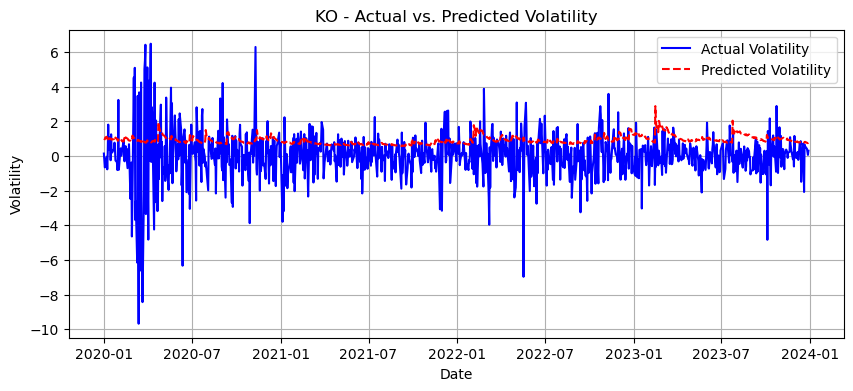

KO - MAE: 1.230881182252438, RMSE: 1.6817605115339715, MAPE: 7695.398725317176%
Processing PG...


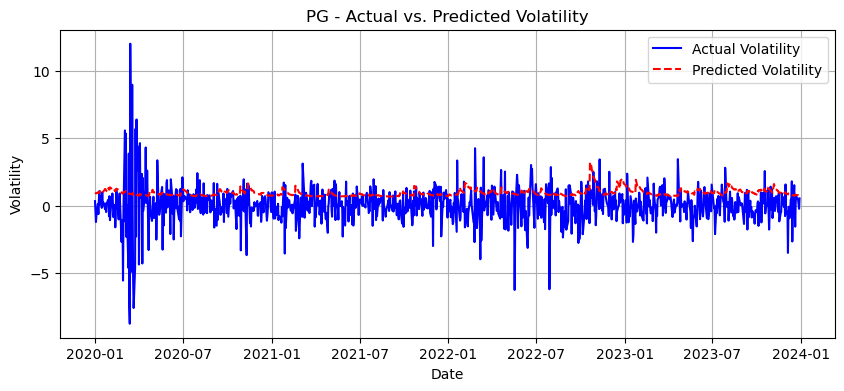

PG - MAE: 1.2481073204101374, RMSE: 1.69743307109877, MAPE: 4157.92902573052%
Processing MSFT...


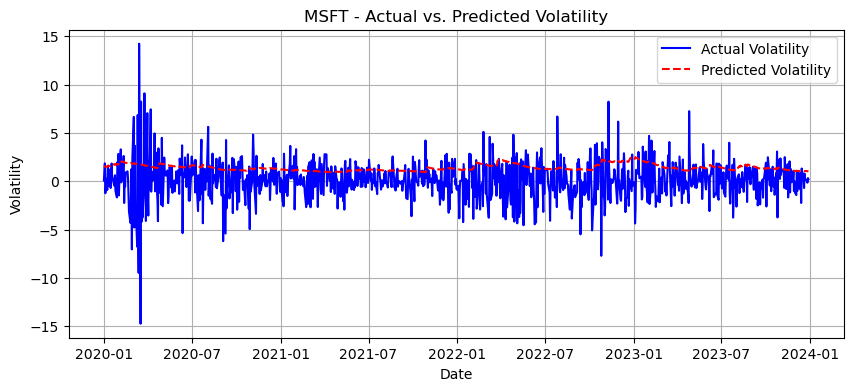

MSFT - MAE: 1.844642674509135, RMSE: 2.4495166835362507, MAPE: 2658.016551608021%
Processing WMT...


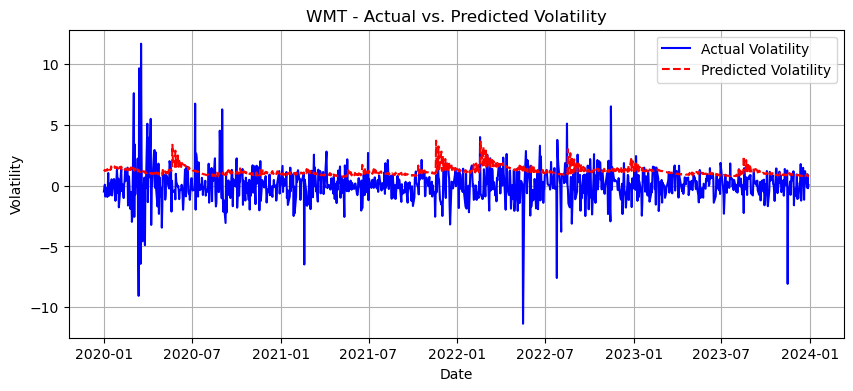

WMT - MAE: 1.4245853706706184, RMSE: 1.9128146898126606, MAPE: 10043.997127464705%
Processing JPM...


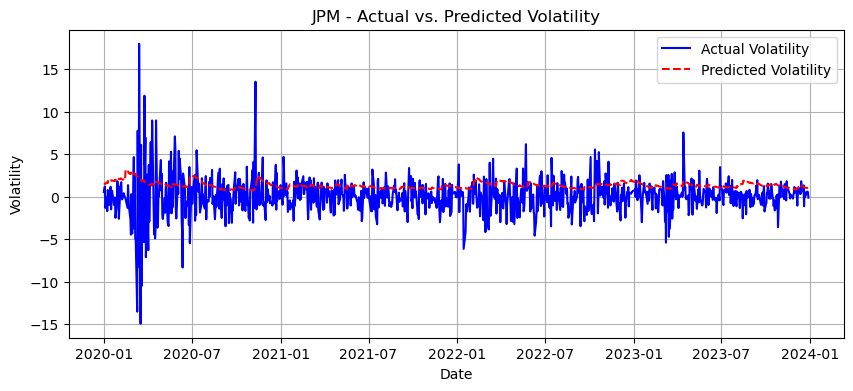

JPM - MAE: 1.873646558618869, RMSE: 2.5635665085580905, MAPE: 5210.672584899793%


In [24]:
# Best parameters found previously
best_params = {
    'KO': {'p': 1, 'q': 4},
    'PG': {'p': 1, 'q': 1},
    'MSFT': {'p': 1, 'q': 1},
    'WMT': {'p': 1, 'q': 3},
    'JPM': {'p': 1, 'q': 1}
}


# Loop for rolling prediction and evaluation
for stock in ['KO', 'PG', 'MSFT', 'WMT', 'JPM']:
    print(f"Processing {stock}...")
    stock_params = best_params[stock]
    rolling_predictions = []
    actuals = []
    test_size = len(test_data[f'{stock}_returns'])

    for i in range(test_size):
        train_set = train_data[f'{stock}_returns'][:-test_size+i]
        model = arch_model(train_set, p=stock_params['p'], q=stock_params['q'])
        model_fit = model.fit(disp='off')
        forecast = model_fit.forecast(horizon=1)
        predicted_vol = np.sqrt(forecast.variance.values[-1, :][0])
        rolling_predictions.append(predicted_vol)
        actuals.append(test_data[f'{stock}_returns'].iloc[-test_size+i])

    # Plotting actual vs predicted volatility
    plt.figure(figsize=(10, 4))
    plt.plot(test_data[f'{stock}_returns'].index[-test_size:], actuals, label='Actual Volatility', color='blue')
    plt.plot(test_data[f'{stock}_returns'].index[-test_size:], rolling_predictions, label='Predicted Volatility', color='red', linestyle='--')
    plt.title(f'{stock} - Actual vs. Predicted Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate error metrics with adjusted MAPE
    mae = mean_absolute_error(actuals, rolling_predictions)
    rmse = np.sqrt(mean_squared_error(actuals, rolling_predictions))
    mape = mean_absolute_percentage_error(actuals, rolling_predictions)

    # Performance output
    print(f"{stock} - MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")

To improve the predictive power of the GARCH model, a rolling forecast evaluation was performed. This approach involves continually updating the model with new data points and making one-step- ahead predictions.

Forecasting for KO


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


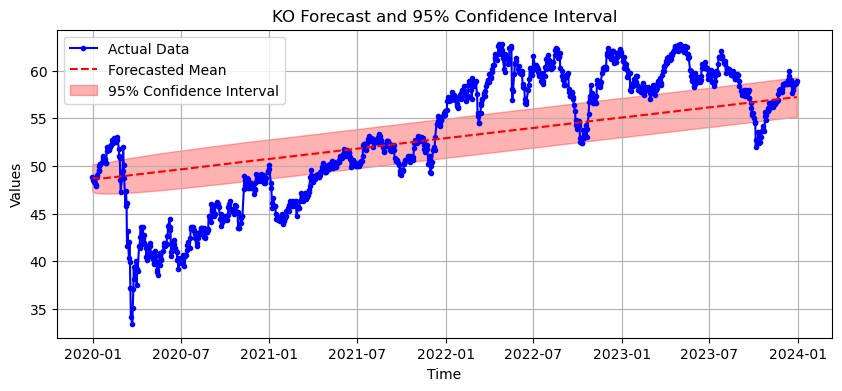

Forecasting for PG


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


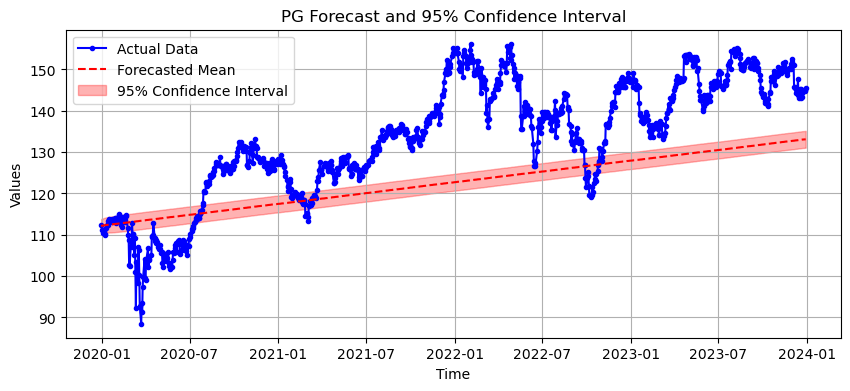

Forecasting for MSFT


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


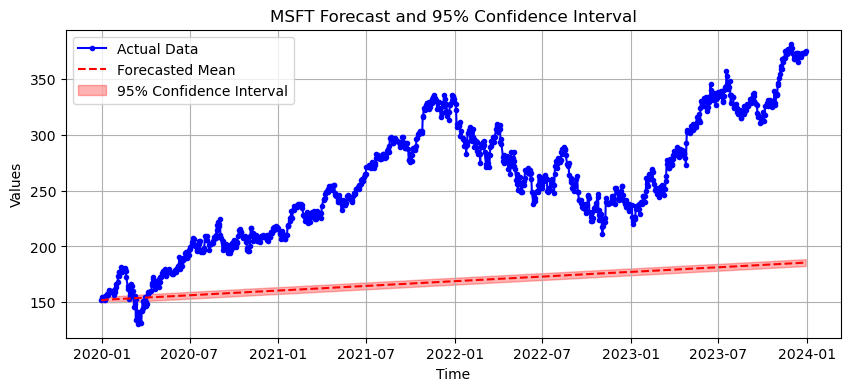

Forecasting for WMT


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


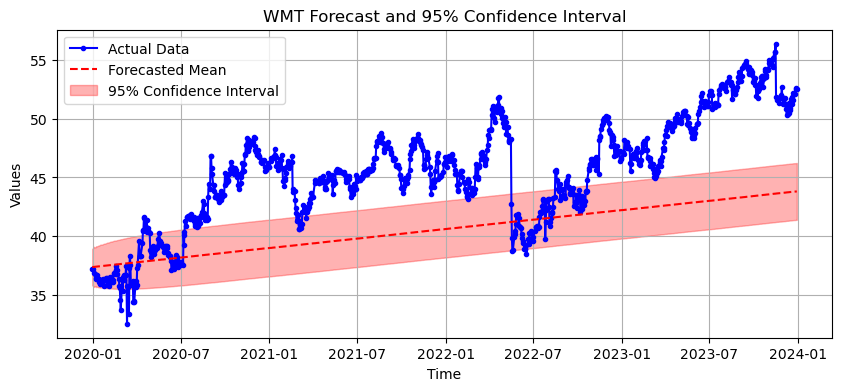

Forecasting for JPM


/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sardorbek/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


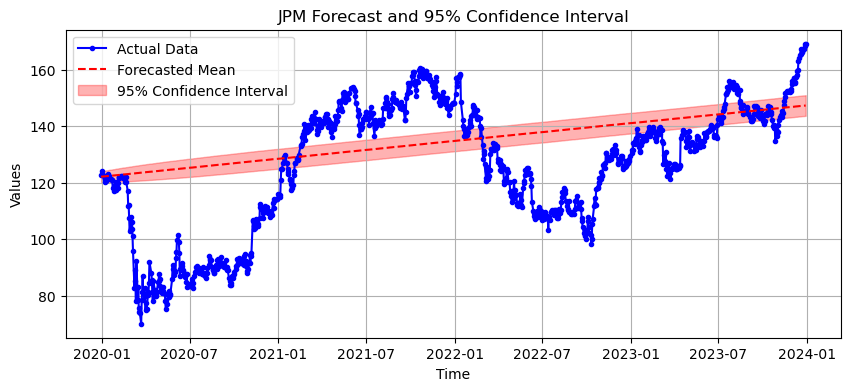

In [47]:
# Define stocks
stocks = ['KO', 'PG', 'MSFT', 'WMT', 'JPM']

# Define the number of periods to forecast
n_periods = len(test_data)  # Ensuring it matches the test data length

# Initialize lists to store final predictions
final_dates = []
final_actuals = []
final_forecasts = []
final_lower_bounds = []
final_upper_bounds = []
final_stocks = []

# Loop through each stock to perform ARIMA and GARCH forecasting
for stock in stocks:
    print(f"Forecasting for {stock}")

    # Retrieve the already fitted models
    arima_model = auto_arima_models[stock]
    garch_model = garch_models[stock]

    # Forecast future mean values with ARIMA
    mean_forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)
    stderr = (conf_int[:, 1] - conf_int[:, 0]) / 2  # Standard errors from the confidence intervals

    # Forecast future volatility with GARCH
    garch_forecast = garch_model.forecast(horizon=n_periods)
    variance_forecast = garch_forecast.variance.iloc[-1].values  # Last row for future variance
    std_dev_forecast = np.sqrt(variance_forecast)

    # Construct 95% prediction intervals
    lower_bound = mean_forecast - 1.96 * std_dev_forecast
    upper_bound = mean_forecast + 1.96 * std_dev_forecast

    # Store the predictions
    final_dates.extend(test_data.index)
    final_actuals.extend(test_data[stock].values)
    final_forecasts.extend(mean_forecast)
    final_lower_bounds.extend(lower_bound)
    final_upper_bounds.extend(upper_bound)
    final_stocks.extend([stock] * n_periods)

    # Plotting
    plt.figure(figsize=(10, 4))
    actual_data = test_data[stock][:n_periods]  # Actual data from test set
    plt.plot(actual_data.index, actual_data, label='Actual Data', color='blue', marker='o', linestyle='-', markersize=3)
    plt.plot(actual_data.index, mean_forecast, label='Forecasted Mean', color='red', linestyle='--')
    plt.fill_between(actual_data.index, lower_bound, upper_bound, color='red', alpha=0.3, label='95% Confidence Interval')
    plt.title(f'{stock} Forecast and 95% Confidence Interval')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [53]:
# Create DataFrame for final predictions
final_predictions_df = pd.DataFrame({
    'Stock': final_stocks,
    'Date': final_dates,
    'Actual': final_actuals,
    'Mean_Forecast': final_forecasts,
    'Lower_Bound': final_lower_bounds,
    'Upper_Bound': final_upper_bounds
})
# Concatenate first and last 3 rows for each stock
final_summary = pd.DataFrame()
for stock in final_predictions_df['Stock'].unique():
    stock_df = final_predictions_df[final_predictions_df['Stock'] == stock]
    summary_df = pd.concat([stock_df.head(3), stock_df.tail(3)])
    final_summary = pd.concat([final_summary, summary_df])

# Reset index for clarity
final_summary.reset_index(drop=True, inplace=True)

# Display the final summary table
print(final_summary)

   Stock        Date  Actual  Mean_Forecast  Lower_Bound  Upper_Bound
0     KO  2019-12-31   48.85      48.748137    47.299968    50.196307
1     KO  2020-01-02   48.53      48.734479    47.258117    50.210840
2     KO  2020-01-03   48.27      48.725215    47.231533    50.218896
3     KO  2023-12-27   58.71      57.208752    55.145856    59.271649
4     KO  2023-12-28   58.75      57.217376    55.154479    59.280273
5     KO  2023-12-29   58.93      57.225999    55.163102    59.288896
6     PG  2019-12-31  112.44     112.100199   110.395893   113.804505
7     PG  2020-01-02  111.09     112.203453   110.472066   113.934841
8     PG  2020-01-03  110.35     112.173058   110.416995   113.929121
9     PG  2023-12-27  145.14     133.076680   131.041135   135.112225
10    PG  2023-12-28  144.82     133.097467   131.061922   135.133012
11    PG  2023-12-29  145.62     133.118254   131.082709   135.153799
12  MSFT  2019-12-31  151.69     151.767057   149.739211   153.794902
13  MSFT  2020-01-02

The final predictions for the five stocks (KO, PG, MSFT, WMT, JPM) are presented in the table above. The predictions include the mean forecast, lower bound, and upper bound for each stock on selected dates. The analysis shows the following:

KO: The forecasted values for KO generally follow the actual values closely, with the prediction intervals capturing the actual stock prices.

PG: Similar to KO, the forecasted values for PG align well with the actual values, and the prediction intervals provide a reasonable range for future prices.

MSFT: The forecasts for MSFT show a significant divergence from the actual values towards the end of the period, indicating that the model may need further refinement to capture the high volatility observed in recent years.

WMT: The forecasted values for WMT exhibit a consistent pattern with the actual values, and the prediction intervals provide a good range for future prices.

JPM: The forecasts for JPM also align well with the actual values, with the prediction intervals capturing the actual prices effectively.

In summary, while the ARIMA and GARCH models provided reasonable predictions for most stocks, further refinement and additional factors may be needed to improve the accuracy of predictions for stocks with higher volatility, such as MSFT.

### Mean-variance Optimization for Portfolio Construction (Efficient Frontier)

#### Data Preparation


For this analysis, I chose to use historical data for the following reasons:
1. Historical data encompasses a broader spectrum of market conditions, offering a reliable basis for estimating returns and risks. This approach aligns with mean-variance optimization, which depends on stable and consistent input data to effectively balance risk and return.
2. The ARIMA models presented varied levels of fit across different stocks, with some models exhibiting higher AIC values and non-normal residuals. These factors cast doubt on the models' ability to accurately forecast future trends. Using these uncertain predictions could potentially lead to less reliable portfolio optimization results.
3. Some of the more complex models, such as the ARIMA(5,1,5) for Microsoft, hinted at possible overfitting. Overfitting can significantly diminish a model's effectiveness on new, unseen data, leading to decisions that might not perform well under future market conditions.
For this analysis, I selected stock price data from the last five years (December 29, 2018, to December 29, 2023). Using this recent data ensures that the analysis reflects current market conditions while still encompassing various market cycles. Recent data captures the latest market trends and conditions, which are crucial for making informed investment decisions. A five-year period includes multiple market cycles, providing a balanced view of performance across different economic conditions.

In [54]:
# Select data from the last 5 years
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=5)
selected_stocks = df.loc[start_date:end_date, ['KO', 'PG', 'MSFT', 'WMT', 'JPM']]

/var/folders/kh/9f_qbyz50xx8zspmkv7h_4f40000gn/T/ipykernel_49859/1687879553.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  selected_stocks = df.loc[start_date:end_date, ['KO', 'PG', 'MSFT', 'WMT', 'JPM']]


For this analysis, I selected stock price data from the last five years (December 29, 2018, to December 29, 2023). Using this recent data ensures that the analysis reflects current market conditions while still encompassing various market cycles. Recent data captures the latest market trends and conditions, which are crucial for making informed investment decisions. A five-year period includes multiple market cycles, providing a balanced view of performance across different economic conditions.

In [67]:
# Calculate daily returns and annual metrics for the selected data
daily_returns = selected_stocks.pct_change().dropna()
annual_returns = daily_returns.mean() * 252  # Annualize the average returns
annual_covariance = daily_returns.cov() * 252  # Annualize the risk
risks = daily_returns.std() * np.sqrt(252)  # Annualize the standard deviation

print("Selected Data Range:", start_date, "to", end_date)
print("Annual Returns:\n", annual_returns)

Selected Data Range: 2018-12-29 00:00:00 to 2023-12-29
Annual Returns:
 KO      0.098120
PG      0.141162
MSFT    0.319158
WMT     0.146460
JPM     0.192331
dtype: float64


In [75]:
print(annual_covariance)

            KO        PG      MSFT       WMT       JPM
KO    0.045764  0.029003  0.029147  0.018515  0.036466
PG    0.029003  0.044766  0.031237  0.024516  0.026373
MSFT  0.029147  0.031237  0.092896  0.027071  0.043725
WMT   0.018515  0.024516  0.027071  0.048682  0.018793
JPM   0.036466  0.026373  0.043725  0.018793  0.101728


The diagonal elements (variances) indicate that JPMorgan Chase (JPM) and Microsoft (MSFT) have the highest risk (volatility), while Coca-Cola (KO) and Procter & Gamble (PG) are more stable. The matrix also highlights potential pairs for diversification. For instance, combining stocks with lower covariances can help reduce overall portfolio volatility.
Annual Returns and Risks: KO: 9.81%, PG: 14.12%, MSFT: 31.92%, WMT: 14.65%, JPM: 19.23%.
These values indicate that Microsoft (MSFT) had the highest average annual return over the past five years, reflecting its strong performance. Coca-Cola (KO) had the lowest return but still positive, indicating steady growth.

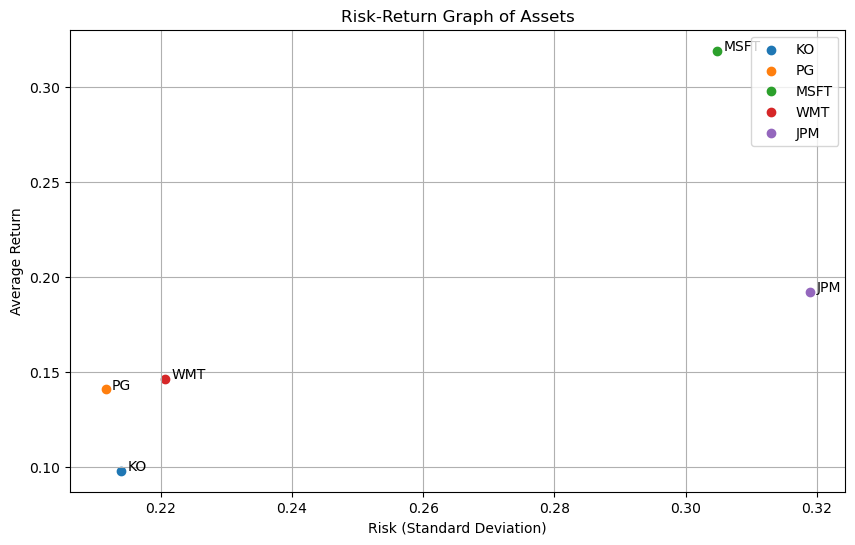

In [57]:
# Plotting risk-return graph
plt.figure(figsize=(10, 6))
for i, asset in enumerate(selected_stocks.columns):
    plt.scatter(risks[asset], annual_returns[asset], label=asset)
    plt.text(risks[asset] + 0.001, annual_returns[asset], asset)

plt.title('Risk-Return Graph of Assets')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Average Return')
plt.grid(True)
plt.legend()
plt.show()

This graph shows the trade-off between risk (standard deviation) and return for each stock. Microsoft (MSFT) appears to have the highest return but also comes with higher risk, while Coca-Cola (KO) has the lowest risk and return.

In [73]:
risk_free_rate = 0.05
trading_days = 252

In [74]:
portfolio_weights = np.array( [0.2,0.2,0.2,0.2,0.2])
# Define the equal weights for each asset
portfolio_weights = np.full((len(daily_returns.columns)), 1/daily_returns.shape[1])

# Calculate portfolio return
portfolio_return = np.sum(daily_returns.mean() * 252 * portfolio_weights)

# Calculate expected volatility
portfolio_volatility = np.sqrt(np.dot(portfolio_weights.T, np.dot(daily_returns.cov() * 252, portfolio_weights)))

# Calculate Sharpe ratio
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

print(f'Portfolio Return: {portfolio_return:.4f}')
print(f'Portfolio Volatility: {portfolio_volatility:.4f}')
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')

Portfolio Return: 0.1794
Portfolio Volatility: 0.1901
Sharpe Ratio: 0.6809


Equal Weight Porfolio was consturcted to provide a benchmark, was constructed where each stock has an equal share. The return, volatility, and Sharpe ratio of this portfolio were calculated: Portfolio Return: 17.94%, Portfolio Volatility: 19.01%, Sharpe Ratio: 0.6809.


In [60]:
# Monte Carlo simulation (University of Bristol, 2024)
np.random.seed(42)  # For reproducibility
num_portfolios = 20000
all_weights = np.zeros((num_portfolios, len(selected_stocks.columns)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

# Monte Carlo simulation (University of Bristol, 2024)
for i in range(num_portfolios):
    weights = np.random.random(len(selected_stocks.columns))
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    all_weights[i,:] = weights
    ret_arr[i] = np.sum(weights * annual_returns)
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(annual_covariance, weights)))
    sharpe_arr[i] = (ret_arr[i] - risk_free_rate / trading_days) / vol_arr[i]

# Find the portfolio with the maximum Sharpe ratio
max_sharpe_idx = sharpe_arr.argmax()
max_sharpe = sharpe_arr[max_sharpe_idx]

# Extract the returns, volatility, and weights of the maximum Sharpe ratio portfolio
max_sharpe_ret = ret_arr[max_sharpe_idx]
max_sharpe_vol = vol_arr[max_sharpe_idx]
max_sharpe_weights = all_weights[max_sharpe_idx, :]

# Print the results
print(f"Maximum Sharpe Ratio: {max_sharpe:.3f}")
print(f"Return of the Maximum Sharpe Ratio Portfolio: {max_sharpe_ret:.3f}")
print(f"Volatility of the Maximum Sharpe Ratio Portfolio: {max_sharpe_vol:.3f}")
print("Weights of the Maximum Sharpe Ratio Portfolio:")
for stock, weight in zip(selected_stocks.columns, max_sharpe_weights):
    print(f"{stock}: {weight:.3%}")

Maximum Sharpe Ratio: 1.084
Return of the Maximum Sharpe Ratio Portfolio: 0.253
Volatility of the Maximum Sharpe Ratio Portfolio: 0.233
Weights of the Maximum Sharpe Ratio Portfolio:
KO: 2.214%
PG: 2.711%
MSFT: 59.708%
WMT: 26.144%
JPM: 9.223%


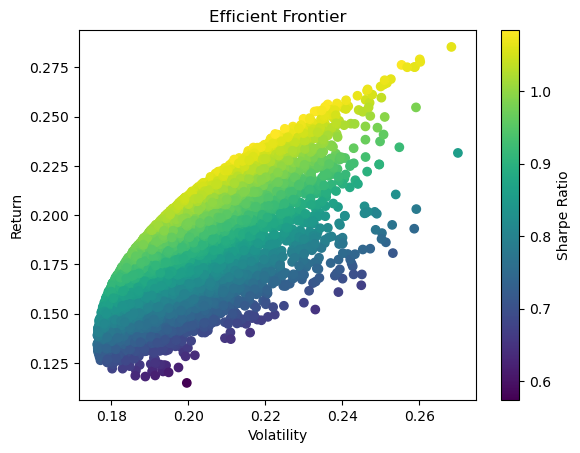

In [61]:
# Plot the efficient frontier (University of Bristol, 2024)
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()

Afterwards, Monte Carlo simulation was employed to construct the efficient frontier. This technique involves generating a large number of random portfolios (20,000 in this case) with different weight combinations for the selected assets. For each portfolio, the expected return, volatility, and Sharpe ratio were calculated. This simulation helps identify the optimal portfolios that offer the highest expected return for a given level of risk.
Steps in Monte Carlo Simulation:
1) Random generation of portfolio weights for the selected assets, ensuring the weights sum to 1. 2) Calculation of the expected return for each portfolio using the generated weights and the annualized returns of the assets. 3) Computation of the portfolio’s risk (standard deviation) using the covariance matrix and the generated weights. 4) Calculation of the Sharpe ratio for each portfolio to evaluate its risk-adjusted return.


The efficient frontier plot shows a range of portfolios, highlighting the trade-offs between return and risk. The portfolios that lie on the frontier represent the best possible combinations of risk and return. The portfolio with the maximum Sharpe ratio, which is the tangency portfolio, was identified as the optimal portfolio.

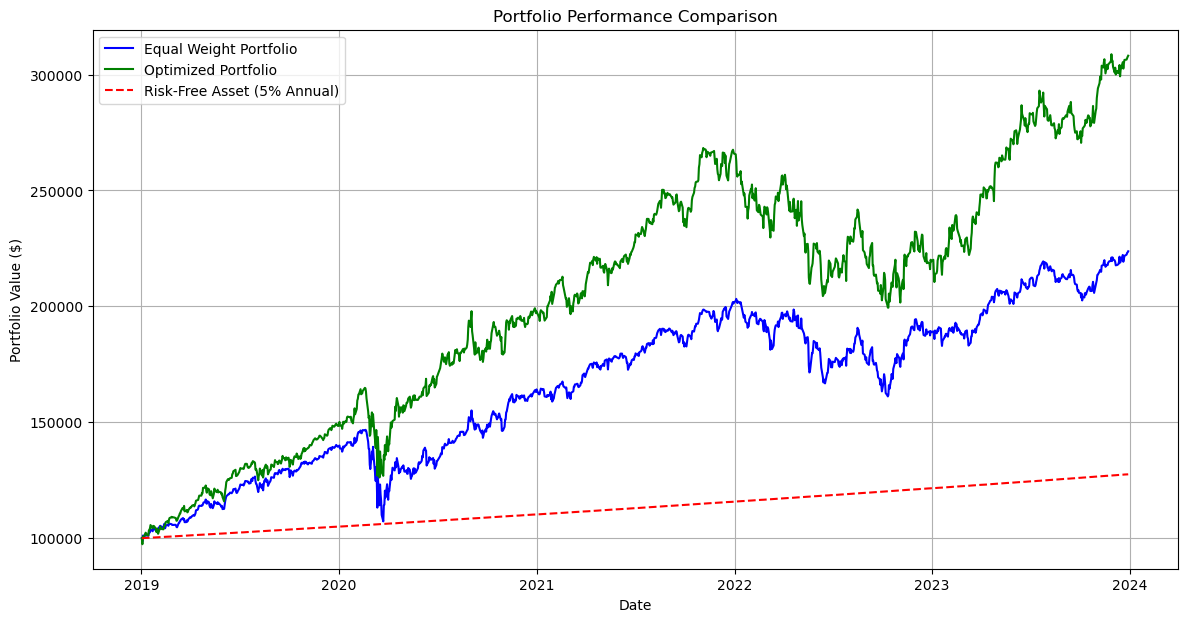

In [62]:
# Calculate daily returns for both portfolios using the weights (University of Bristol, 2024)
equal_weight_returns = daily_returns.dot(portfolio_weights)
optimized_weight_returns = daily_returns.dot(max_sharpe_weights)

# Calculate cumulative returns for both portfolios from an initial investment
initial_investment = 100000
cumulative_returns_equal = (1 + equal_weight_returns).cumprod() * initial_investment
cumulative_returns_optimized = (1 + optimized_weight_returns).cumprod() * initial_investment

# Assuming the risk-free rate is an annual 5%, calculate its daily equivalent
daily_risk_free_return = (1 + risk_free_rate) ** (1 / 252) - 1  # Convert annual rate to daily

# Generate an array of the risk-free returns over the same number of days as the daily_returns dataset
risk_free_returns = np.full(daily_returns.shape[0], daily_risk_free_return)
risk_free_performance = initial_investment * (1 + risk_free_returns).cumprod()

# Plotting the performance of both portfolios and the risk-free asset
plt.figure(figsize=(14, 7))
plt.plot(daily_returns.index, cumulative_returns_equal, label='Equal Weight Portfolio', color='blue')
plt.plot(daily_returns.index, cumulative_returns_optimized, label='Optimized Portfolio', color='green')
plt.plot(daily_returns.index, risk_free_performance, label='Risk-Free Asset (5% Annual)', linestyle='--', color='red')
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

The comparison shows that the optimized portfolio outperforms the equal weight portfolio and the risk-free asset, demonstrating the benefits of optimization. The optimized portfolio not only provides higher returns but also maintains a favorable risk- adjusted return compared to the baseline and risk-free assets.

## Principal Component Analysis (PCA) for Return Allocation

In [76]:
warnings.filterwarnings('ignore')

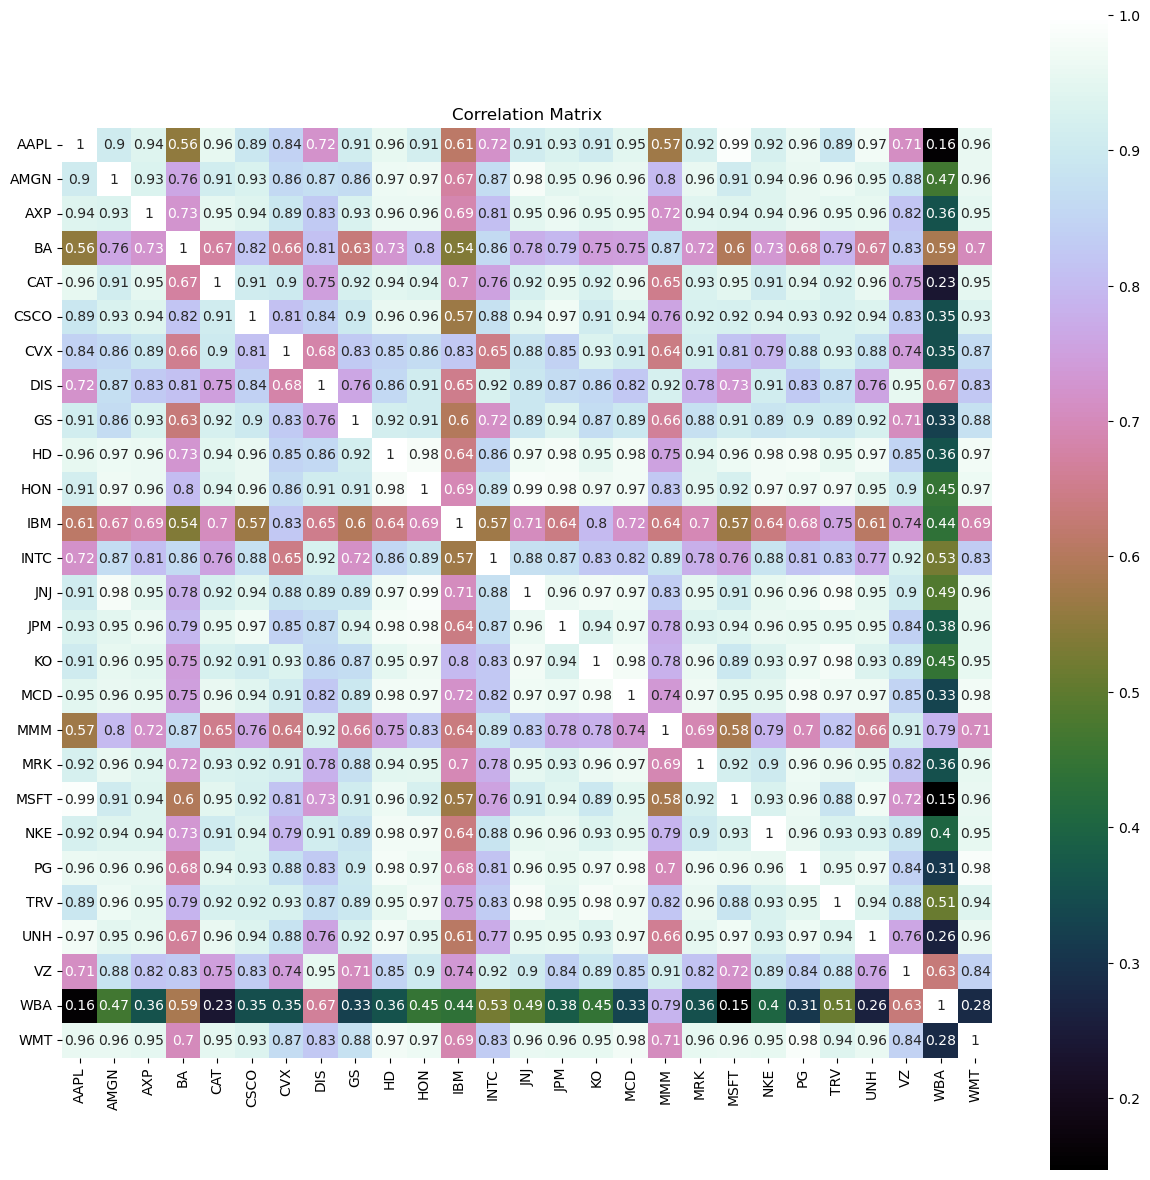

In [77]:
# Calculate the correlation matrix
correlation = df.corr()


# Plot the correlation matrix (University of Bristol, 2024)
plt.figure(figsize=(15, 15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.show()

Most stocks are positively correlated with each other, indicated by the numerous areas of light colors, reflecting correlation values close to 1. This suggests that stock prices generally move in the same direction, reflecting common market influences. Some stocks show slightly lower correlations, indicated by darker shades. These areas represent potential opportunities for diversification within a portfolio.
The high correlations across most stocks indicate that PCA could effectively reduce dimensionality without losing significant information. The first few principal components might capture the majority of the variance. Stocks with lower correlations could be crucial in constructing portfolios that aim for risk reduction through diversification.

In [78]:
# Check for any null values and print them
print('Null Values =', df.isnull().values.any())


Null Values = False


In [79]:
# Calculate daily percentage changes (returns)
datareturns = np.log(df / df.shift(1)) 


datareturns.describe()

AAPL         AMGN          AXP           BA          CAT  \
count  5032.000000  5032.000000  5032.000000  5032.000000  5032.000000   
mean      0.001272     0.000368     0.000356     0.000437     0.000492   
std       0.020859     0.016114     0.021965     0.021727     0.019865   
min      -0.198954    -0.100740    -0.193623    -0.272444    -0.156756   
25%      -0.008650    -0.007785    -0.007515    -0.009230    -0.009025   
50%       0.000533     0.000076     0.000438     0.000699     0.000674   
75%       0.011996     0.008590     0.009222     0.010469     0.010596   
max       0.127970     0.140533     0.197904     0.217678     0.137429   

              CSCO          CVX          DIS           GS           HD  ...  \
count  5032.000000  5032.000000  5032.000000  5032.000000  5032.000000  ...   
mean      0.000220     0.000395     0.000310     0.000332     0.000549  ...   
std       0.018041     0.017886     0.017387     0.021761     0.016395  ...   
min      -0.176603    -0.250034    -0.141164    -0.210092    -0.220579  ...   
25%      -0.007589    -0.007804    -0.007651    -0.009247    -0.007213  ...   
50%       0.000497     0.000808     0.000348     0.000458     0.000637  ...   
75%       0.008854     0.009049     0.008271     0.010387     0.008452  ...   
max       0.147180     0.204794     0.148562     0.234857     0.131971  ...   

               MMM          MRK         MSFT          NKE           PG  \
count  5032.000000  5032.000000  5032.000000  5032.000000  5032.000000   
mean      0.000168     0.000321     0.000613     0.000554     0.000325   
std       0.014526     0.015982     0.017004     0.017685     0.011351   
min      -0.138624    -0.311653    -0.159463    -0.137006    -0.091438   
25%      -0.006021    -0.006631    -0.007240    -0.007612    -0.004873   
50%       0.000516     0.000447     0.000479     0.000560     0.000424   
75%       0.007336     0.007990     0.008787     0.008890     0.005883   
max       0.118659     0.122044     0.170650     0.144402     0.113460   

               TRV          UNH           VZ          WBA          WMT  
count  5032.000000  5032.000000  5032.000000  5032.000000  5032.000000  
mean      0.000409     0.000615     0.000228     0.000032     0.000300  
std       0.017056     0.019200     0.012833     0.017769     0.012602  
min      -0.233186    -0.206017    -0.084485    -0.162519    -0.120740  
25%      -0.006703    -0.007804    -0.006266    -0.008366    -0.005820  
50%       0.000709     0.000694     0.000419     0.000000     0.000504  
75%       0.007704     0.009128     0.006693     0.008933     0.006403  
max       0.227919     0.298332     0.136328     0.153837     0.110674  

[8 rows x 27 columns]

In [80]:
# Remove outliers beyond 3 standard deviations
datareturns = datareturns[datareturns.apply(lambda x: np.abs(x - x.mean()) <= (3 * x.std())).all(axis=1)]

In [81]:
datareturns.describe()

AAPL         AMGN          AXP           BA          CAT  \
count  4157.000000  4157.000000  4157.000000  4157.000000  4157.000000   
mean      0.001609     0.000501     0.000552     0.000749     0.000748   
std       0.016855     0.012686     0.014368     0.015834     0.015573   
min      -0.059903    -0.046401    -0.058563    -0.063475    -0.056552   
25%      -0.007605    -0.007150    -0.006587    -0.008454    -0.008084   
50%       0.000661     0.000228     0.000536     0.000817     0.000760   
75%       0.011427     0.008150     0.008447     0.009871     0.009837   
max       0.063179     0.048634     0.063823     0.063360     0.059747   

              CSCO          CVX          DIS           GS           HD  ...  \
count  4157.000000  4157.000000  4157.000000  4157.000000  4157.000000  ...   
mean      0.000728     0.000543     0.000435     0.000550     0.000685  ...   
std       0.012994     0.013251     0.012844     0.015320     0.012502  ...   
min      -0.053803    -0.050450    -0.050706    -0.060025    -0.046924  ...   
25%      -0.006678    -0.007134    -0.006670    -0.008457    -0.006498  ...   
50%       0.000668     0.000848     0.000434     0.000575     0.000687  ...   
75%       0.008355     0.008452     0.007753     0.009699     0.007960  ...   
max       0.053566     0.051897     0.051764     0.064367     0.049030  ...   

               MMM          MRK         MSFT          NKE           PG  \
count  4157.000000  4157.000000  4157.000000  4157.000000  4157.000000   
mean      0.000444     0.000645     0.000924     0.000751     0.000501   
std       0.010779     0.011287     0.012648     0.013047     0.008610   
min      -0.042400    -0.047295    -0.047111    -0.051517    -0.033075   
25%      -0.005308    -0.005921    -0.006398    -0.006773    -0.004407   
50%       0.000533     0.000560     0.000469     0.000739     0.000526   
75%       0.006840     0.007462     0.008271     0.008386     0.005502   
max       0.042983     0.045930     0.051593     0.053203     0.034003   

               TRV          UNH           VZ          WBA          WMT  
count  4157.000000  4157.000000  4157.000000  4157.000000  4157.000000  
mean      0.000551     0.000790     0.000341     0.000359     0.000405  
std       0.011682     0.013869     0.009978     0.013693     0.009548  
min      -0.050167    -0.054091    -0.037108    -0.053233    -0.037142  
25%      -0.005862    -0.007090    -0.005679    -0.007654    -0.005290  
50%       0.000775     0.000737     0.000630     0.000000     0.000520  
75%       0.007239     0.008491     0.006402     0.008288     0.006159  
max       0.050062     0.058016     0.037184     0.052919     0.037823  

[8 rows x 27 columns]

In [82]:
#(University of Bristol, 2024)
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

AAPL      AMGN       AXP        BA       CAT      CSCO  \
Date                                                                     
2004-01-05  3.501727 -0.039506  0.563623  0.083660  1.668745  1.551861   
2004-01-06 -1.866803  0.223888  0.094644 -0.265688 -1.196041  0.847902   

                 CVX       DIS        GS        HD  ...       MMM       MRK  \
Date                                                ...                       
2004-01-05  1.402996  1.468632 -0.008732 -0.054784  ...  1.710225  1.684694   
2004-01-06 -0.445448  0.166954 -0.426923  0.822724  ... -0.337457 -0.459159   

                MSFT       NKE        PG       TRV       UNH        VZ  \
Date                                                                     
2004-01-05  1.886132 -0.057573  0.512526  0.165070 -3.601222  2.817965   
2004-01-06  0.196476 -0.172758 -0.629013 -0.721139  0.672272  1.606424   

                 WBA      WMT  
Date                           
2004-01-05 -0.960903 -0.40363  
2004-01-06 -0.498093  2.37167  

[2 rows x 27 columns]

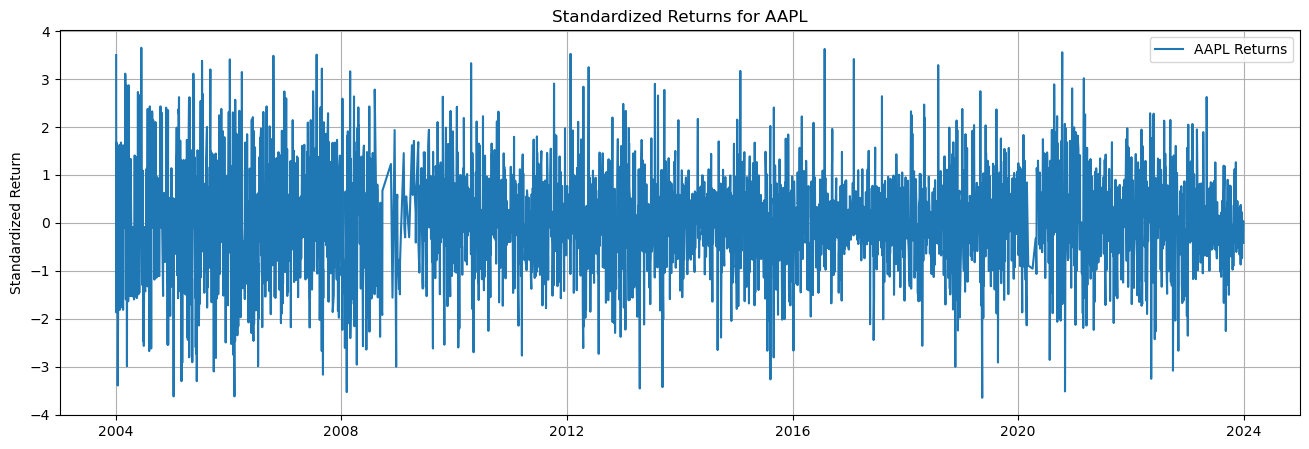

In [83]:
# Visualizing standardized returns for a specific stock, e.g., AAPL
plt.figure(figsize=(16, 5))
plt.title("Standardized Returns for AAPL")
plt.ylabel("Standardized Return")
plt.plot(rescaledDataset.index, rescaledDataset['AAPL'], label='AAPL Returns')
plt.grid(True)
plt.legend()
plt.show()

In [84]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.8)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = rescaledDataset.columns.values
n_tickers = len(stock_tickers)

In [85]:
X_train.describe()

AAPL         AMGN          AXP           BA          CAT  \
count  3325.000000  3325.000000  3325.000000  3325.000000  3325.000000   
mean     -0.006990    -0.008394     0.000620     0.006319    -0.008292   
std       1.014274     1.020941     0.957853     0.898838     0.992632   
min      -3.649856    -3.697480    -4.075327    -4.055516    -3.679949   
25%      -0.553655    -0.623485    -0.466787    -0.518524    -0.562170   
50%      -0.080624    -0.029138    -0.003746     0.007267    -0.003142   
75%       0.562303     0.605355     0.502478     0.546147     0.570730   
max       3.653286     3.794532     4.404006     3.954593     3.789060   

              CSCO          CVX          DIS           GS           HD  ...  \
count  3325.000000  3325.000000  3325.000000  3325.000000  3325.000000  ...   
mean     -0.004790     0.003457     0.014434    -0.009191    -0.006761  ...   
std       1.016230     0.951224     0.933254     0.994917     0.994242  ...   
min      -4.064173    -3.848518    -3.982047    -3.954458    -3.808668  ...   
25%      -0.572367    -0.550858    -0.504043    -0.578296    -0.571943  ...   
50%      -0.004639     0.029391     0.019248     0.001042    -0.012823  ...   
75%       0.595856     0.578048     0.562528     0.584666     0.547225  ...   
max       4.066905     3.875860     3.996657     4.166004     3.616225  ...   

               MMM          MRK         MSFT          NKE           PG  \
count  3325.000000  3325.000000  3325.000000  3325.000000  3325.000000   
mean      0.014073    -0.005246    -0.016513     0.002332    -0.001267   
std       0.950658     1.003397     0.952966     0.954336     0.975460   
min      -3.933850    -4.247798    -3.798223    -4.006651    -3.899981   
25%      -0.502247    -0.589173    -0.567138    -0.539381    -0.552857   
50%       0.019599    -0.015529    -0.045374     0.004786    -0.009641   
75%       0.566193     0.603108     0.518225     0.561802     0.545243   
max       3.946920     4.012647     4.006454     4.020734     3.849750   

               TRV          UNH           VZ          WBA          WMT  
count  3325.000000  3325.000000  3325.000000  3325.000000  3325.000000  
mean      0.002443    -0.002887     0.014206     0.006768    -0.009791  
std       0.964946     1.021462     1.006848     0.956218     1.000381  
min      -4.188200    -3.727970    -3.714051    -3.914213    -3.932807  
25%      -0.535575    -0.576460    -0.607910    -0.555774    -0.596014  
50%       0.010290    -0.007455     0.036469    -0.002160     0.008929  
75%       0.553337     0.561916     0.629236     0.559733     0.588794  
max       4.238566     4.126840     3.693071     3.838777     3.919151  

[8 rows x 27 columns]

In [86]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)
print(pca.components_.shape)

(27, 27)


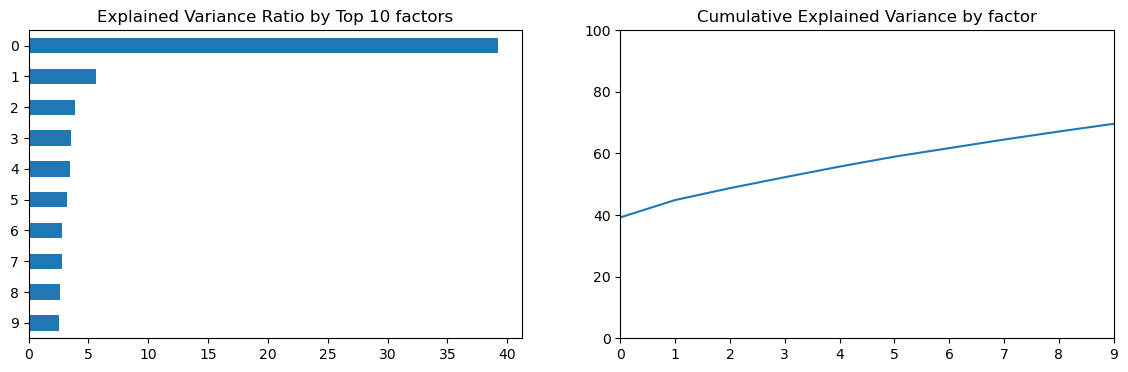

In [87]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

The plot shows that the most important factor explains around 39.26% of the daily return variation. The cumulative explained variance indicates that 10 factors explain around 69.63% of the returns.
To allocate weights to assets in a portfolio using PCA, it is important to normalize the weights. This normalization ensures that the weights add up to one, making them suitable for portfolio construction. Here, the approach of traditional normalization was chosen. This approach ensures that each principal component’s weights are scaled such that their sum equals one. The contribution of different stocks in each eigenvector was visualized. This helps in understanding the composition of each principal component and its relevance to portfolio allocation.


In [132]:
# (University of Bristol, 2024)
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        
#         Approach one: rigidly follow the traditional normalisation 
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])
        

    weights = weights.values.T
    return weights

weights=PCWeights()

In [89]:
# Analyze a specific component
print(pca.components_[1])

[ 0.21532294 -0.22465779  0.155778    0.12046868  0.25534592  0.16750505
  0.10569352  0.05677178  0.29244636 -0.01144376  0.14556579  0.03976015
  0.13229797 -0.3056927   0.23953151 -0.29993003 -0.18277553  0.05901115
 -0.28301161  0.06808766  0.03922895 -0.32937096 -0.02373155 -0.14067648
 -0.21366533 -0.1607595  -0.25792855]


In [90]:
weights[1]

array([-0.6317636 ,  0.65915231, -0.45705705, -0.35345852, -0.74919213,
       -0.49146454, -0.31010779, -0.16656999, -0.85804588,  0.03357632,
       -0.42709416, -0.11665741, -0.388166  ,  0.89691102, -0.70279221,
        0.88000319,  0.53626857, -0.17314038,  0.83036405, -0.19977113,
       -0.11509885,  0.96638371,  0.06962903,  0.41274878,  0.62690012,
        0.47167292,  0.75676964])

In [91]:
# Number of components to analyze
NumComponents = 5
print(pca.components_[:NumComponents])

[[-1.61383301e-01 -1.76020012e-01 -2.14695581e-01 -1.74301049e-01
  -2.09753686e-01 -2.21224345e-01 -1.74860485e-01 -1.95701165e-01
  -2.10241390e-01 -2.04114595e-01 -2.36815024e-01 -2.13179615e-01
  -1.92002359e-01 -1.90174152e-01 -2.25003804e-01 -1.79081957e-01
  -1.72472096e-01 -2.27086908e-01 -1.77535638e-01 -1.95414326e-01
  -1.77101721e-01 -1.78338979e-01 -1.98549623e-01 -1.53619781e-01
  -1.74113639e-01 -1.62232540e-01 -1.66492011e-01]
 [ 2.15322943e-01 -2.24657792e-01  1.55778000e-01  1.20468684e-01
   2.55345917e-01  1.67505046e-01  1.05693525e-01  5.67717756e-02
   2.92446360e-01 -1.14437604e-02  1.45565795e-01  3.97601525e-02
   1.32297975e-01 -3.05692699e-01  2.39531507e-01 -2.99930031e-01
  -1.82775531e-01  5.90111495e-02 -2.83011607e-01  6.80876629e-02
   3.92289504e-02 -3.29370961e-01 -2.37315475e-02 -1.40676483e-01
  -2.13665331e-01 -1.60759500e-01 -2.57928546e-01]
 [-4.66232349e-01 -2.50218998e-01  2.47756048e-01  3.72096352e-02
  -1.98446676e-02 -2.68706088e-01 -1.073

array([[<Axes: title={'center': 'Portfolio 0'}>],
       [<Axes: title={'center': 'Portfolio 1'}>],
       [<Axes: title={'center': 'Portfolio 2'}>],
       [<Axes: title={'center': 'Portfolio 3'}>],
       [<Axes: title={'center': 'Portfolio 4'}>]], dtype=object)

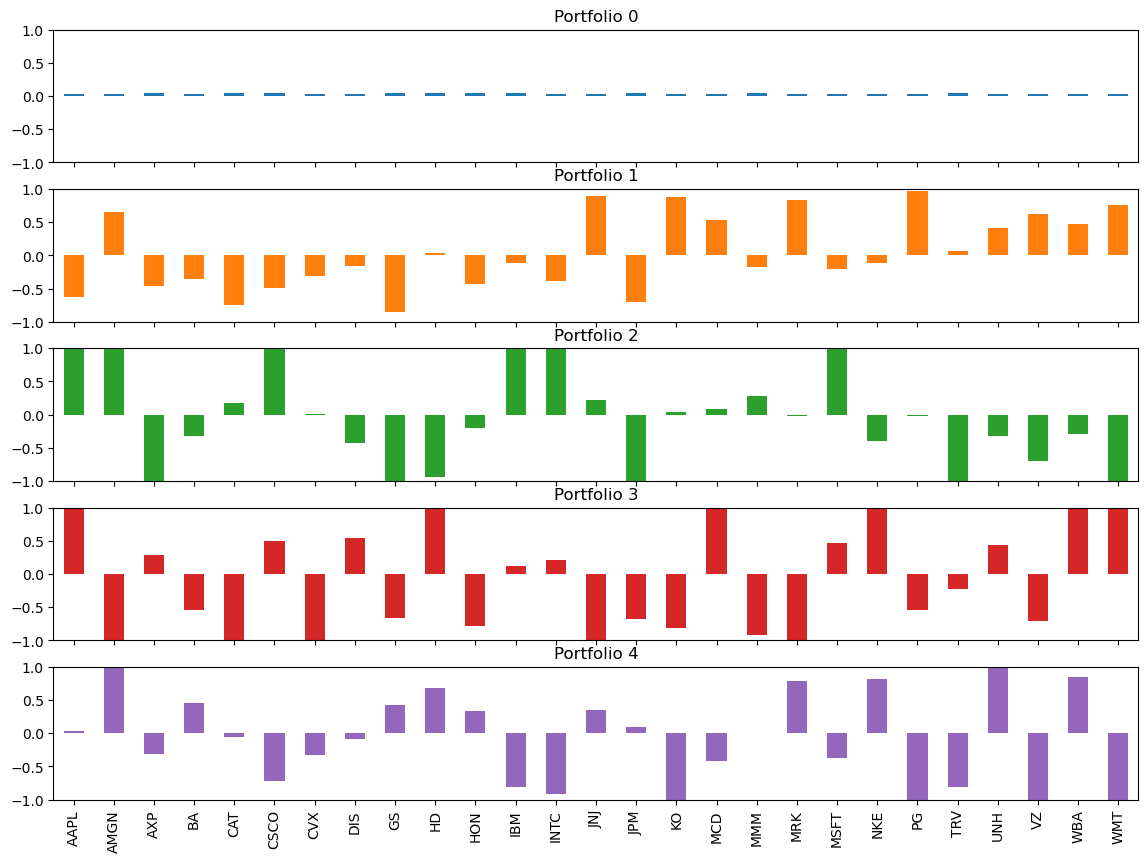

In [92]:
# (University of Bristol, 2024)
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=df.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
# np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1))

The plot shows the allocation of stocks in the top 5 principal components (Portfolios). Interestingly, the first principal component (Portfolio 0) appears as an roughly equal-weighted portfolio. Portfolios 1 through 4 show more differentiated allocations, with varying positive and negative weights across different stocks.

<Axes: >

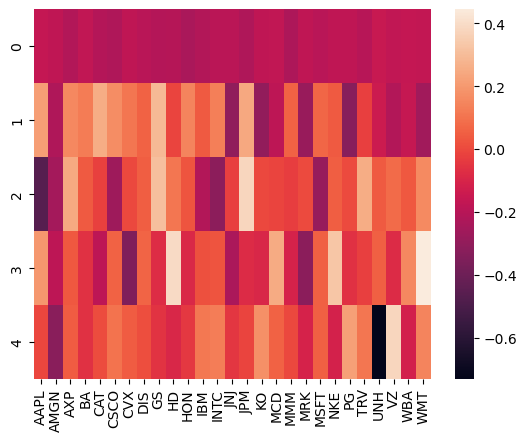

In [93]:
# Plotting heatmap
sns.heatmap(topPortfolios)

In [94]:
# Sharpe Ratio (University of Bristol, 2024)
def sharpe_ratio(ts_returns, periods_per_year=252):
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Eigen portfolio #0 with the highest Sharpe. Return 15.14%, vol = 12.28%, Sharpe = 1.23
      Return        Vol    Sharpe
0   0.151386   0.122787  1.232916
8   0.309271   0.872160  0.354604
7   0.001633   1.189926  0.001372
9  -0.999999  23.279039 -0.042957
20 -1.000000  11.863928 -0.084289
14 -0.126393   0.745629 -0.169512
12 -1.000000   5.869261 -0.170379
24 -0.172147   0.797419 -0.215881
22 -0.201352   0.877370 -0.229495
25 -0.999973   4.166641 -0.239995
26 -0.999914   4.054696 -0.246606
2  -0.487891   1.948905 -0.250341
5  -0.999279   3.842479 -0.260061
13 -0.999925   3.774728 -0.264900
4  -0.400111   1.415271 -0.282710
3  -0.447349   1.566242 -0.285619
15 -0.993008   3.171024 -0.313151
10 -0.968202   2.835397 -0.341470
21 -0.707286   2.067033 -0.342174
23 -0.669147   1.746840 -0.383061


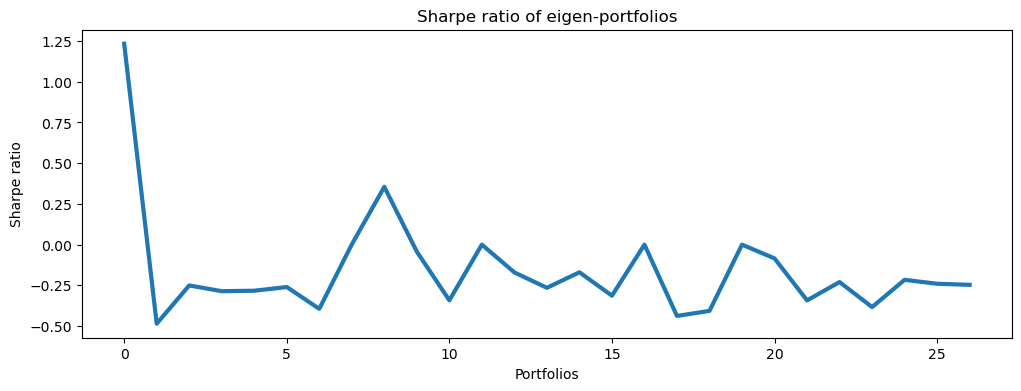

In [134]:
# (University of Bristol, 2024)
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    for i in range(n_portfolios):
         
        pc_w = pcs[i] / sum(pcs[i])

        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric= np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()

optimizedPortfolio()

The eigen-portfolio with the highest Sharpe ratio is identified as Portfolio #0 with a Sharpe ratio of 1.23, an annualized return of 15.14%, and annualized volatility of 12.28%. The sharpe ratio for other porfolios flactuate around 0 with only 3 portfolios with positive sharpe ratio.

Sum of weights of current eigen-portfolio: 100.00


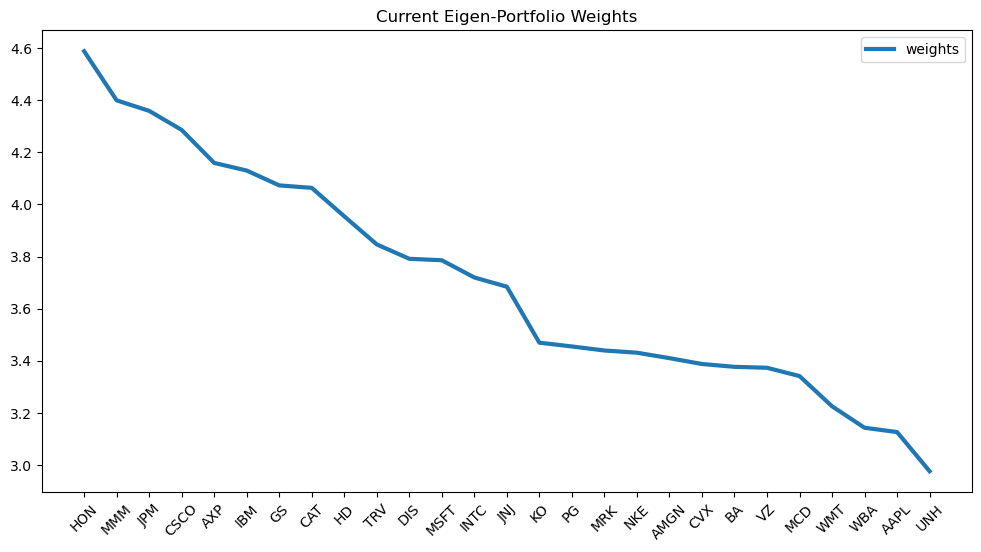

weights
HON   4.588096
MMM   4.399622
JPM   4.359263
CSCO  4.286039
AXP   4.159550
IBM   4.130179
GS    4.073254
CAT   4.063805
HD    3.954552
TRV   3.846735
DIS   3.791549
MSFT  3.785992
INTC  3.719888
JNJ   3.684468
KO    3.469565
PG    3.455171
MRK   3.439607
NKE   3.431200
AMGN  3.410243
CVX   3.387778
BA    3.376939
VZ    3.373308
MCD   3.341505
WMT   3.225646
WBA   3.143122
AAPL  3.126669
UNH   2.976257

In [98]:
# (University of Bristol, 2024)
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[0], plot=True)

Current Eigen-Portfolio:
Return = 17.97%
Volatility = 12.64%
Sharpe = 1.42


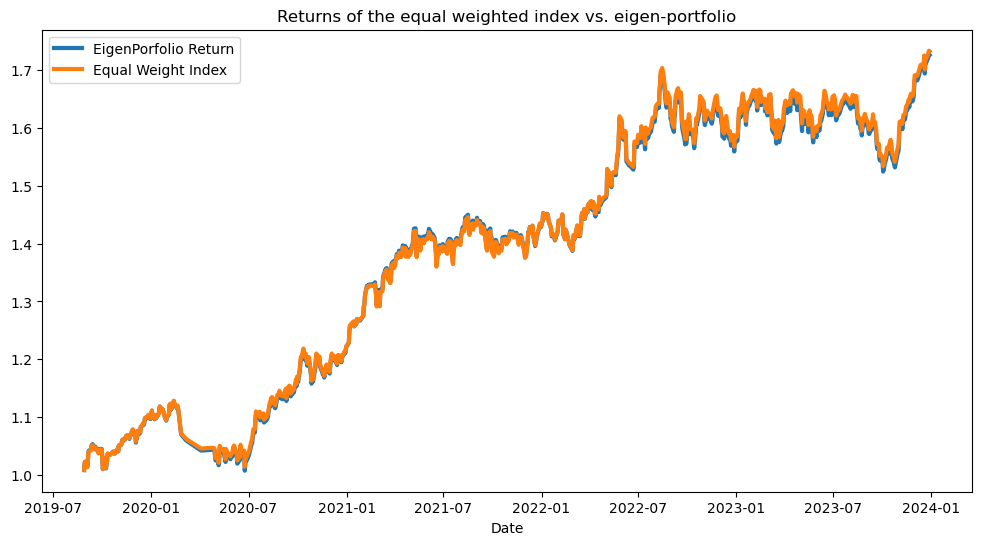

Current Eigen-Portfolio:
Return = 61.02%
Volatility = 73.80%
Sharpe = 0.83


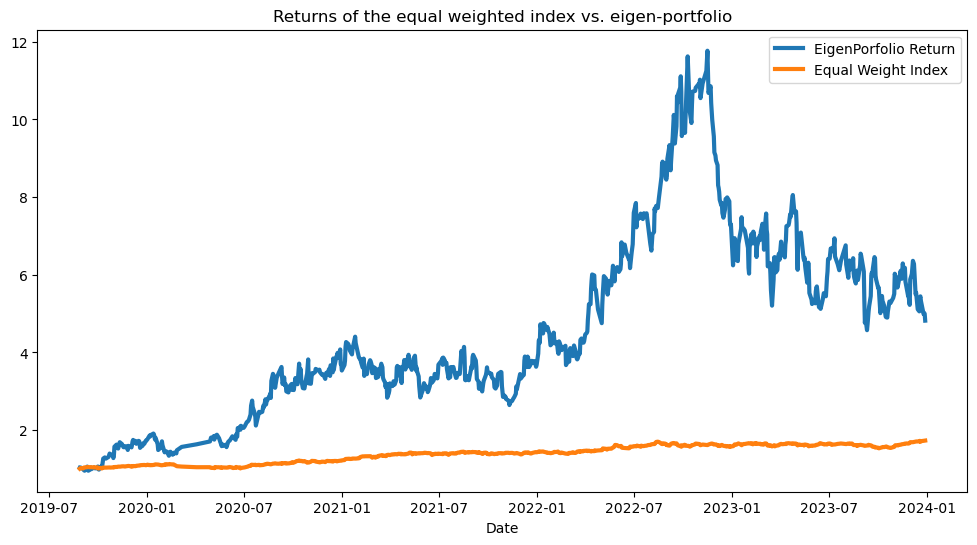

Current Eigen-Portfolio:
Return = 31.87%
Volatility = 126.71%
Sharpe = 0.25


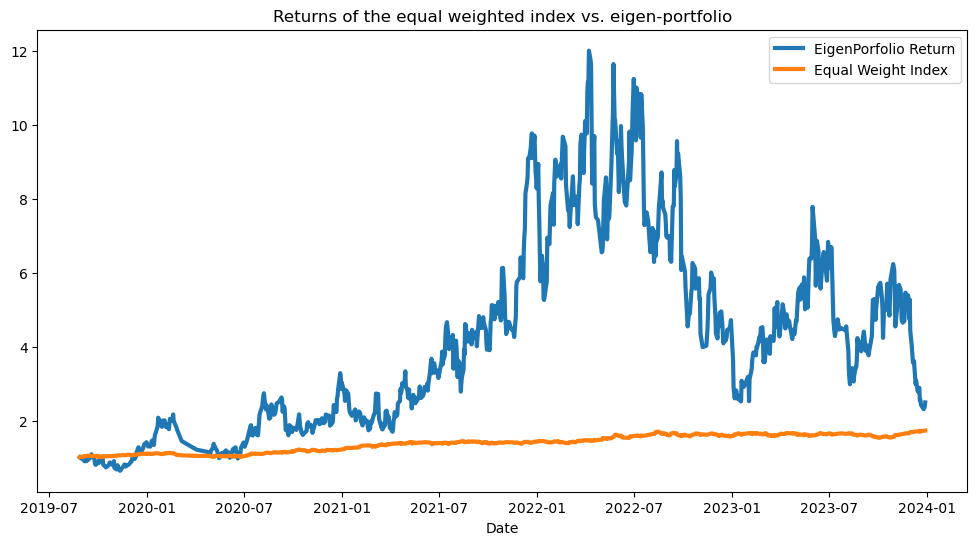

In [99]:
# (University of Bristol, 2024)
def Backtest(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''
   
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , 
                          figsize=(12,6), linewidth=3)
    plt.show()

Backtest(eigen=weights[0])
Backtest(eigen=weights[8])
Backtest(eigen=weights[7])

The backtest for the 0 eigen-portfolio shows a return of 17.97%, volatility of 12.64%, and a Sharpe ratio of 1.42. The performance of the eigen-portfolio is slightly better than the equal-weight index, indicating effective risk-adjusted returns.
The backtest for the eighth eigen-portfolio shows a return of 61.02%, volatility of 73.80%, and a Sharpe ratio of 0.83. While the return is significantly higher, the volatility is also much higher, resulting in a lower Sharpe ratio.
The backtest for the seventh eigen-portfolio shows a return of 31.87%, volatility of 126.71%, and a Sharpe ratio of 0.25. The high volatility reduces the attractiveness of this portfolio despite its substantial returns.

Interestingly, the most efficient portfolio turned out to be a roughly equal-weighted portfolio. This outcome is somewhat unexpected, as one would typically anticipate that PCA would generate more differentiated weights.

## Hierarchical Risk Parity

#### Data Transformation

In [100]:
# Calculate daily percentage changes (returns)
returns = np.log(df / df.shift(1)) 
# Drop rows with any missing values to ensure dataset completeness
returns.dropna(inplace=True)

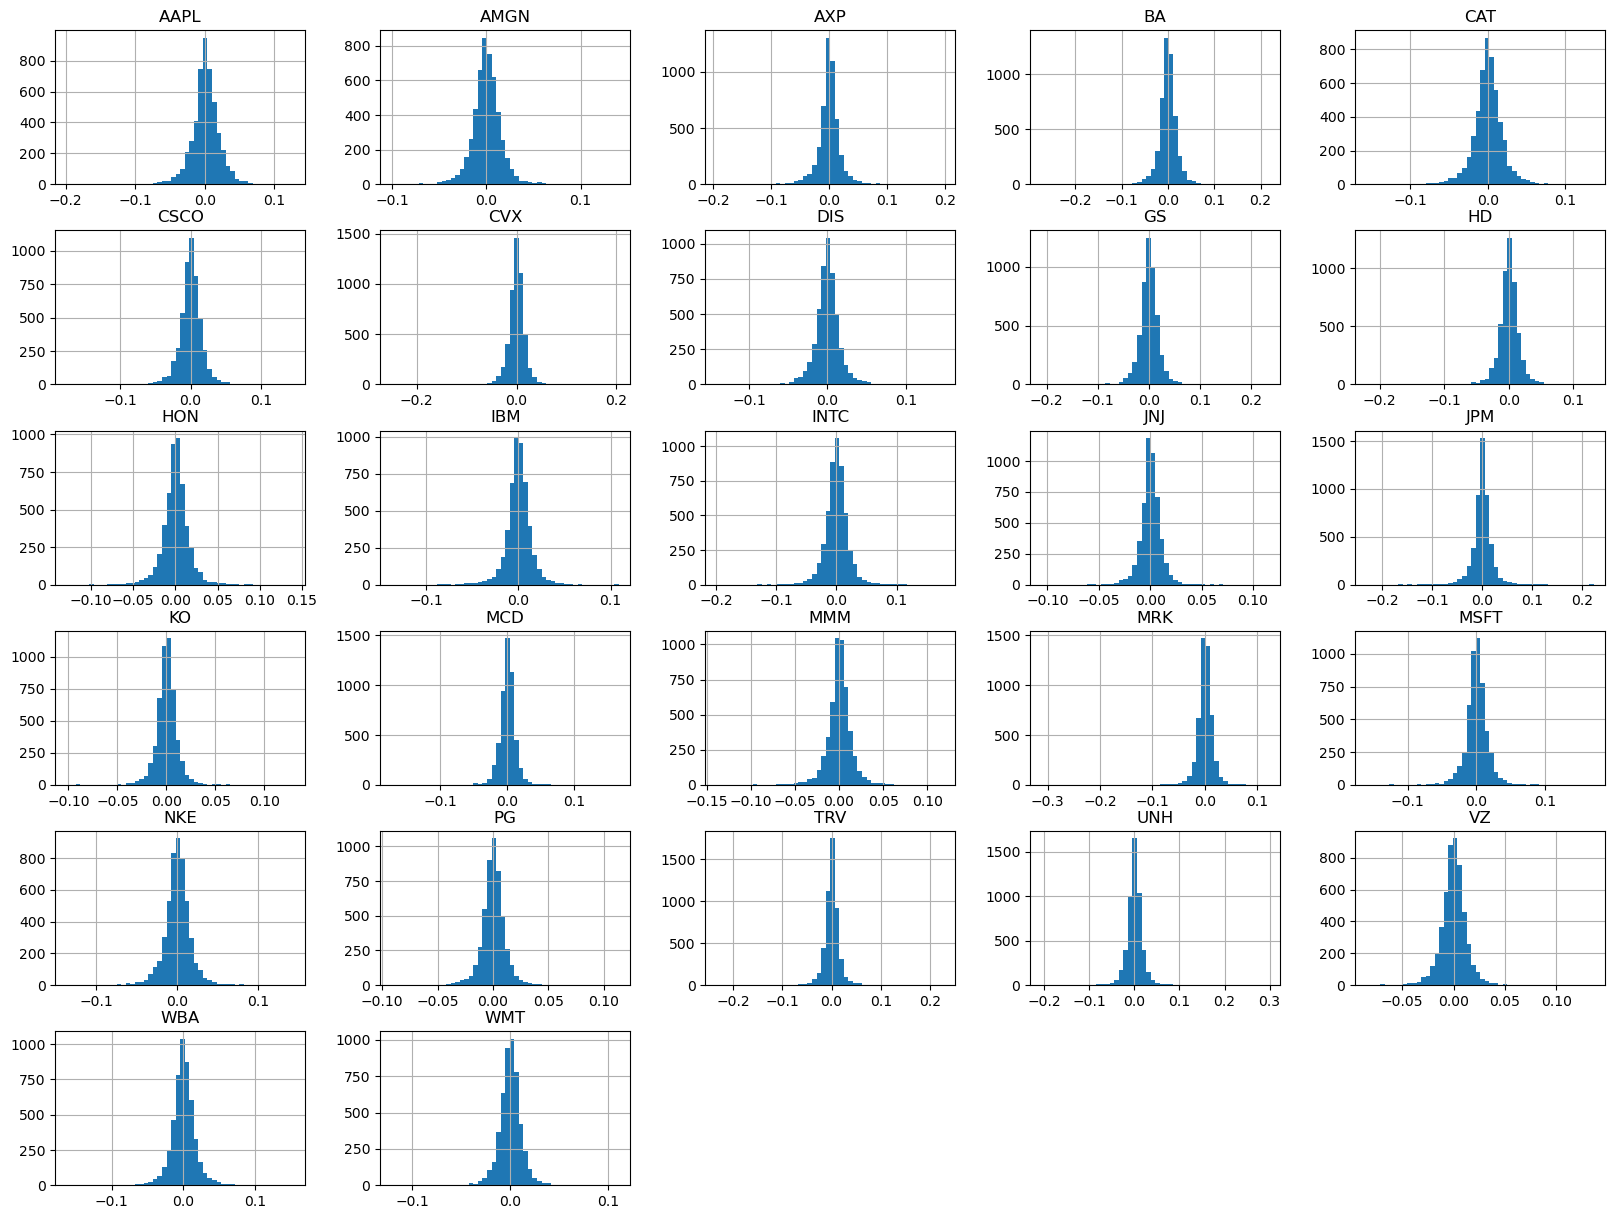

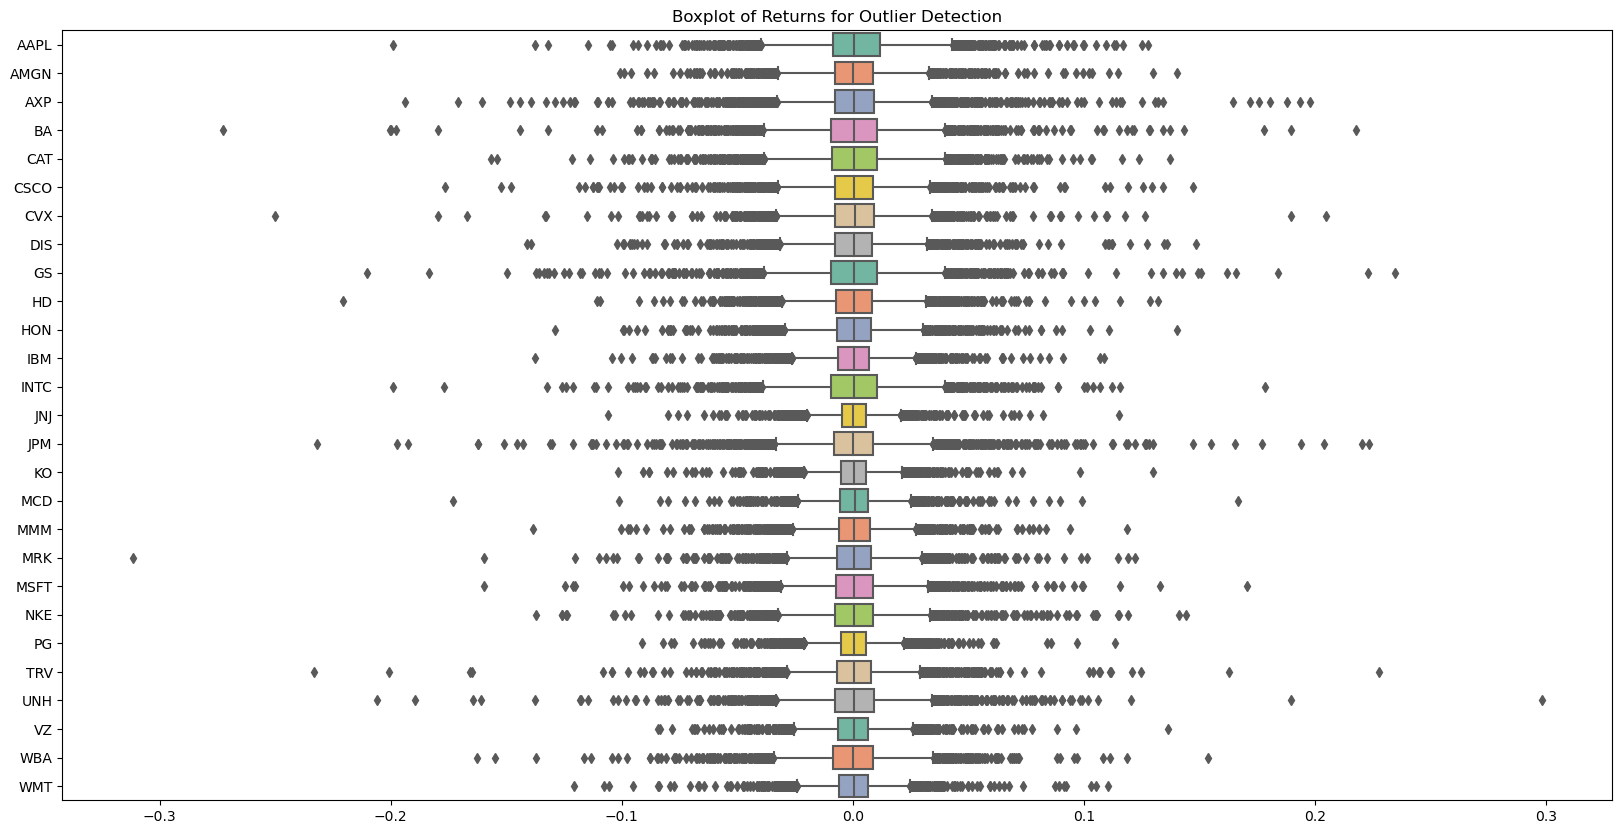

In [101]:
# Plot histograms for each stock's returns to visualize the distribution
returns.hist(bins=50, figsize=(20, 15))
plt.show()

# Additionally, use boxplots to visually inspect potential outliers
plt.figure(figsize=(20, 10))
sns.boxplot(data=returns, orient="h", palette="Set2")
plt.title('Boxplot of Returns for Outlier Detection')
plt.show()

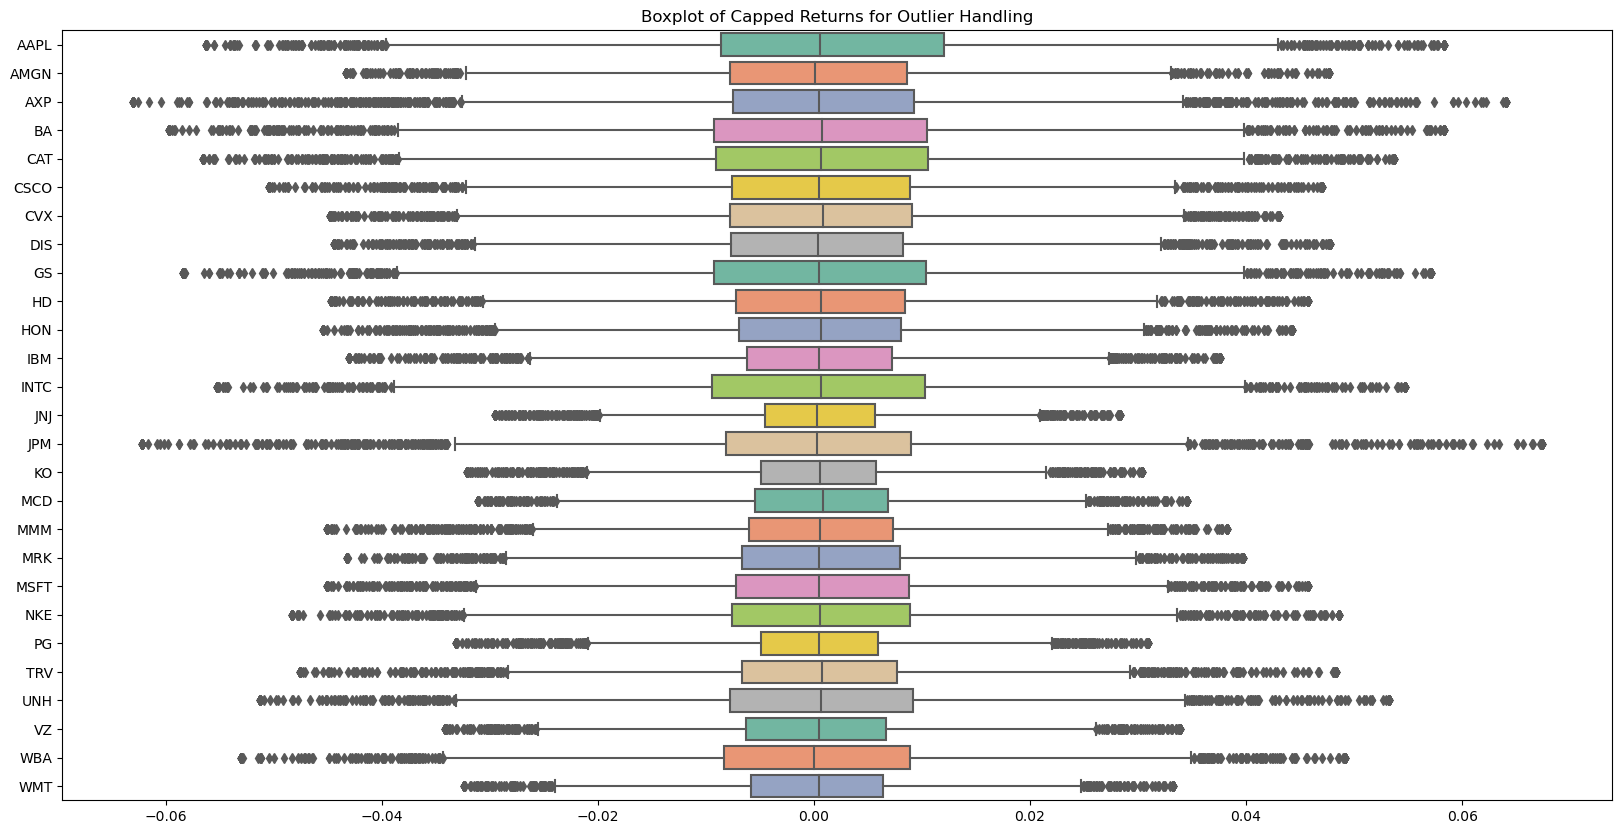

In [102]:
# Apply a capping method to handle outliers based on quantiles
quantile_low = returns.quantile(0.01)
quantile_high = returns.quantile(0.99)

returns_capped = returns.clip(quantile_low, quantile_high, axis=1)

# Visual confirmation after capping
plt.figure(figsize=(20, 10))
sns.boxplot(data=returns_capped, orient="h", palette="Set2")
plt.title('Boxplot of Capped Returns for Outlier Handling')
plt.show()

Outliers can significantly affect the results of the analysis. To detect and handle outliers, box plots were used for visual inspection. The returns were capped based on the 1st and 99th quantiles to mitigate the impact of extreme values. This ensures that the data remains robust against the influence of outliers.

##### Split the data into training and testing sets (80% train, 20% test)

In [107]:
train_size = int(len(returns) * 0.8)
returns_train = returns_capped[:train_size]
returns_test = returns_capped[train_size:]

In [108]:
returns_train

AAPL      AMGN       AXP        BA       CAT      CSCO  \
Date                                                                     
2004-01-05  0.058335  0.000000  0.008650  0.002073  0.026732  0.020890   
2004-01-06 -0.029853  0.003341  0.001912 -0.003458 -0.017875  0.011744   
2004-01-07  0.029853  0.013035  0.002861  0.008279 -0.010881  0.020226   
2004-01-08  0.028988 -0.000220 -0.002861  0.013647 -0.007728  0.029870   
2004-01-09  0.000000 -0.005724 -0.007670 -0.005096 -0.017299  0.004985   
...              ...       ...       ...       ...       ...       ...   
2019-12-23  0.016199 -0.000094 -0.010269  0.028690  0.006262  0.013609   
2019-12-24  0.001013 -0.002911  0.002045 -0.013562 -0.006860 -0.006662   
2019-12-26  0.019618 -0.001789  0.005349 -0.009287  0.005001  0.001431   
2019-12-27 -0.000426 -0.001509 -0.001780  0.000671  0.000372 -0.001670   
2019-12-30  0.005941 -0.005251 -0.007151 -0.011400 -0.005074 -0.003828   

                 CVX       DIS        GS        HD  ...       MMM       MRK  \
Date                                                ...                       
2004-01-05  0.019132  0.019297  0.000417  0.000000  ...  0.018877  0.019658   
2004-01-06 -0.005359  0.002579 -0.005989  0.010969  ... -0.003193 -0.004537   
2004-01-07 -0.012783  0.016352  0.020876  0.013544  ... -0.017418  0.000909   
2004-01-08  0.000989  0.014591  0.001231 -0.008105  ... -0.006747  0.005437   
2004-01-09 -0.010935 -0.003503 -0.012790  0.002258  ... -0.003281 -0.020083   
...              ...       ...       ...       ...  ...       ...       ...   
2019-12-23  0.005447 -0.015072  0.000679 -0.009004  ...  0.017538  0.001686   
2019-12-24  0.000101  0.004221  0.003583  0.006648  ... -0.010091 -0.003245   
2019-12-26  0.002110  0.002827  0.005639  0.000702  ... -0.000477 -0.001041   
2019-12-27 -0.002412  0.000344 -0.002406 -0.003870  ...  0.003739  0.001691   
2019-12-30 -0.003831 -0.013723 -0.003717 -0.012159  ... -0.008038 -0.005080   

                MSFT       NKE        PG       TRV       UNH        VZ  \
Date                                                                     
2004-01-05  0.024778  0.000000  0.004914  0.002479 -0.049148  0.028454   
2004-01-06  0.003409 -0.001503 -0.004914 -0.007872  0.010112  0.016367   
2004-01-07 -0.001135  0.003003 -0.009191  0.000000  0.009144  0.002432   
2004-01-08 -0.001705  0.010440  0.010597  0.006634  0.002165  0.015267   
2004-01-09 -0.017791 -0.007446  0.005257  0.016394 -0.009125 -0.029950   
...              ...       ...       ...       ...       ...       ...   
2019-12-23  0.000000  0.000836 -0.003640 -0.001537  0.008508 -0.010785   
2019-12-24 -0.000198  0.000940  0.002487 -0.002919 -0.001876 -0.001843   
2019-12-26  0.008158  0.005724  0.000000  0.003404  0.003785  0.000000   
2019-12-27  0.001833  0.008473  0.006984  0.003715  0.001079  0.003887   
2019-12-30 -0.008671 -0.007643 -0.012946 -0.002260 -0.007179 -0.005117   

                 WBA       WMT  
Date                            
2004-01-05 -0.012797 -0.003448  
2004-01-06 -0.006461  0.023048  
2004-01-07 -0.016807  0.002528  
2004-01-08  0.000941 -0.003373  
2004-01-09 -0.018036 -0.017036  
...              ...       ...  
2019-12-23  0.002944 -0.010681  
2019-12-24 -0.003576  0.004019  
2019-12-26  0.009228  0.000000  
2019-12-27  0.002086  0.000802  
2019-12-30 -0.001877 -0.001604  

[4025 rows x 27 columns]

In [109]:
returns_test

AAPL      AMGN       AXP        BA       CAT      CSCO  \
Date                                                                     
2019-12-31  0.007306  0.003362  0.001537 -0.001974  0.001047  0.007879   
2020-01-02  0.022563 -0.004026  0.014313  0.022957  0.019095  0.016744   
2020-01-03 -0.009766 -0.006858 -0.009972 -0.001691 -0.013952 -0.016268   
2020-01-06  0.007985  0.007665 -0.004341  0.002958 -0.000669  0.003559   
2020-01-07 -0.004811 -0.009434 -0.005217  0.010554 -0.013330 -0.006654   
...              ...       ...       ...       ...       ...       ...   
2023-12-22 -0.005570  0.017170  0.004226 -0.006048  0.001004  0.007675   
2023-12-26 -0.002849 -0.000923  0.002106  0.008983  0.018002  0.003816   
2023-12-27  0.000519  0.009223  0.005917 -0.002629  0.008392  0.003202   
2023-12-28  0.002227  0.006696  0.003961 -0.006699 -0.004187  0.000799   
2023-12-29 -0.005446 -0.001503 -0.002460  0.001190 -0.004069  0.000798   

                 CVX       DIS        GS        HD  ...       MMM       MRK  \
Date                                                ...                       
2019-12-31  0.005540  0.005983  0.000580  0.004881  ...  0.003346 -0.000915   
2020-01-02  0.007605  0.024395  0.018910  0.005867  ...  0.020043  0.011825   
2020-01-03 -0.003495 -0.011575 -0.011783 -0.003334  ... -0.008656 -0.008563   
2020-01-06 -0.003407 -0.005769  0.010169  0.004694  ...  0.001010  0.004290   
2020-01-07 -0.012829  0.000344  0.006581 -0.006568  ... -0.004048 -0.026956   
...              ...       ...       ...       ...  ...       ...       ...   
2023-12-22  0.002278 -0.010927  0.000212 -0.001096  ...  0.007197  0.012238   
2023-12-26  0.008928 -0.000769  0.002510  0.002047  ...  0.016594 -0.000650   
2023-12-27 -0.003255 -0.006287  0.007493 -0.002220  ...  0.005813  0.003247   
2023-12-28 -0.014208  0.000221  0.005017 -0.003383  ...  0.008750  0.007290   
2023-12-29 -0.004058 -0.001218 -0.001643 -0.002320  ... -0.003435  0.002296   

                MSFT       NKE        PG       TRV       UNH        VZ  \
Date                                                                     
2019-12-31  0.000725  0.005067  0.003475  0.003388  0.000434  0.003073   
2020-01-02  0.018290  0.008730 -0.012079  0.004018 -0.005043 -0.005745   
2020-01-03 -0.012506 -0.002662 -0.006684 -0.003535 -0.010199 -0.010757   
2020-01-06  0.002553 -0.000923  0.001358  0.001126  0.006920 -0.002082   
2020-01-07 -0.009129 -0.000513 -0.006173 -0.014821 -0.006039 -0.011108   
...              ...       ...       ...       ...       ...       ...   
2023-12-22  0.002785 -0.048305  0.007090  0.001244  0.000830  0.001629   
2023-12-26  0.000214 -0.000186  0.004492  0.006897 -0.000540 -0.000271   
2023-12-27 -0.001579 -0.008303  0.000827  0.008182  0.005295 -0.004623   
2023-12-28  0.003235  0.015615 -0.002207  0.003721  0.004025  0.004894   
2023-12-29  0.002027 -0.002308  0.005509  0.006136  0.002979  0.005410   

                 WBA       WMT  
Date                            
2019-12-31  0.000835 -0.004828  
2020-01-02  0.002083  0.000806  
2020-01-03  0.000000 -0.008906  
2020-01-06  0.008497 -0.001899  
2020-01-07 -0.004965 -0.009277  
...              ...       ...  
2023-12-22  0.006190  0.011944  
2023-12-26  0.014548 -0.001533  
2023-12-27  0.001140  0.009354  
2023-12-28 -0.001520 -0.002092  
2023-12-29 -0.018420  0.000571  

[1007 rows x 27 columns]

##### Hierarchical Clustering Implementation

In [110]:
# Define a function to calculate the correlation distance
def correlDist(corr):
    dist = ((1 - corr) / 2.)**0.5  # Distance matrix
    return dist


In [111]:
# Calculate the correlation matrix for training data
corr = returns_train.corr()

# Calculate the correlation distance
dist = correlDist(corr)

In [112]:
# Perform hierarchical clustering using the 'ward' method
linkage_matrix = linkage(dist, 'ward')

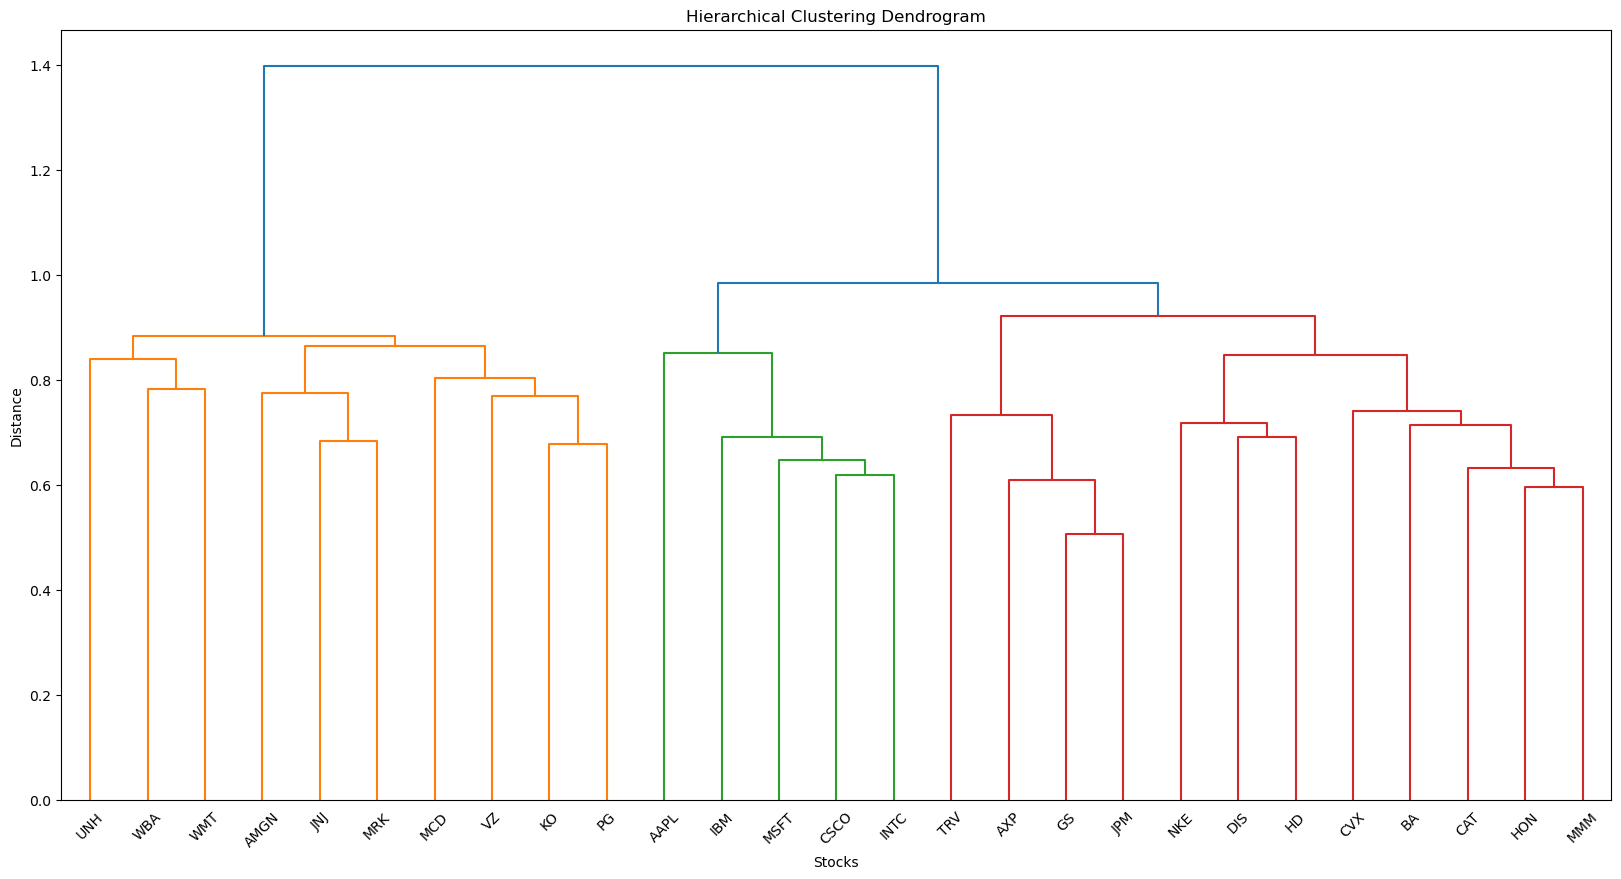

In [113]:
# Plot the dendrogram
plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix, labels=corr.columns)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Stocks')
plt.ylabel('Distance')
plt.show()

The next step involved hierarchical clustering to identify natural groupings among the assets. This process included computing a correlation-distance matrix and constructing a dendrogram to visualize the hierarchical structure.
A correlation-distance matrix was calculated from the correlation matrix of the returns. The 'ward' linkage method was used to perform hierarchical clustering, which helps in minimizing the variance within each cluster.

• Cluster 1 (Orange): Low-volatility, stable-return stocks from sectors like consumer staples and healthcare (e.g., UNH, WBA, WMT).

• Cluster 2 (Green): Technology stocks with higher growth and volatility (e.g., AAPL, IBM, MSFT).

• Cluster 3 (Red): Cyclical stocks sensitive to economic changes (e.g., JPM, GS, DIS).


Cluster 1 is more distinct from Clusters 2 and 3, indicating different risk-return profiles. Clusters 2 and 3 are closer, suggesting some correlation due to economic sensitivity. Grouping stocks by clusters aids in diversification. Combining stocks from different clusters can reduce overall portfolio risk. HRP uses these clusters to balance risk contributions, preventing any single cluster from dominating the portfolio's risk profile.

##### Quasi-Diagonalization

In [114]:
# Define a function to get quasi-diagonalization (University of Bristol, 2024)
def getQuasiDiag(link):
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # Number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # Make space
        df0 = sortIx[sortIx >= numItems]  # Find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # Item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # Item 2
        sortIx = sortIx.sort_index()  # Re-sort
        sortIx.index = range(sortIx.shape[0])  # Re-index
    return sortIx.tolist()

In [115]:
# Quasi-diagonalization
sorted_index = getQuasiDiag(linkage_matrix)
sorted_corr = corr.iloc[sorted_index, sorted_index]

In [116]:
sorted_corr

UNH       WBA       WMT      AMGN       JNJ       MRK       MCD  \
UNH   1.000000  0.360447  0.296859  0.348838  0.384388  0.368850  0.324007   
WBA   0.360447  1.000000  0.397216  0.363319  0.412314  0.355151  0.337450   
WMT   0.296859  0.397216  1.000000  0.313624  0.401222  0.352745  0.383213   
AMGN  0.348838  0.363319  0.313624  1.000000  0.469723  0.430503  0.343548   
JNJ   0.384388  0.412314  0.401222  0.469723  1.000000  0.539561  0.377870   
MRK   0.368850  0.355151  0.352745  0.430503  0.539561  1.000000  0.356404   
MCD   0.324007  0.337450  0.383213  0.343548  0.377870  0.356404  1.000000   
VZ    0.283668  0.331883  0.396502  0.329135  0.441709  0.411503  0.362270   
KO    0.338223  0.357383  0.392502  0.352579  0.475552  0.439216  0.423038   
PG    0.325355  0.398517  0.422846  0.381239  0.509793  0.446381  0.428286   
AAPL  0.277320  0.316877  0.257574  0.313938  0.277128  0.272294  0.325579   
IBM   0.351413  0.406186  0.388604  0.371454  0.435907  0.386258  0.385908   
MSFT  0.353672  0.402078  0.358185  0.413873  0.425711  0.390324  0.407027   
CSCO  0.339097  0.396562  0.374735  0.382351  0.422057  0.397312  0.390783   
INTC  0.320997  0.378929  0.351328  0.385723  0.388357  0.379695  0.365956   
TRV   0.370082  0.385112  0.417759  0.355224  0.451896  0.417784  0.431167   
AXP   0.377153  0.404167  0.375001  0.357562  0.410494  0.410518  0.410128   
GS    0.363658  0.398680  0.355587  0.341139  0.380248  0.375267  0.354234   
JPM   0.375624  0.410004  0.382474  0.348045  0.407301  0.401787  0.386387   
NKE   0.356716  0.381196  0.378629  0.334311  0.366564  0.333921  0.407667   
DIS   0.383920  0.428007  0.390787  0.387691  0.433881  0.424275  0.417667   
HD    0.383171  0.445882  0.486708  0.366979  0.405493  0.372343  0.433794   
CVX   0.354944  0.356704  0.301885  0.355277  0.406790  0.392102  0.367119   
BA    0.366841  0.385245  0.326612  0.347159  0.406490  0.363824  0.385870   
CAT   0.340192  0.380928  0.331349  0.337925  0.382181  0.343519  0.360552   
HON   0.404962  0.440726  0.390935  0.415846  0.460009  0.434198  0.435863   
MMM   0.393815  0.429651  0.396831  0.410692  0.503993  0.420893  0.425067   

            VZ        KO        PG  ...        GS       JPM       NKE  \
UNH   0.283668  0.338223  0.325355  ...  0.363658  0.375624  0.356716   
WBA   0.331883  0.357383  0.398517  ...  0.398680  0.410004  0.381196   
WMT   0.396502  0.392502  0.422846  ...  0.355587  0.382474  0.378629   
AMGN  0.329135  0.352579  0.381239  ...  0.341139  0.348045  0.334311   
JNJ   0.441709  0.475552  0.509793  ...  0.380248  0.407301  0.366564   
MRK   0.411503  0.439216  0.446381  ...  0.375267  0.401787  0.333921   
MCD   0.362270  0.423038  0.428286  ...  0.354234  0.386387  0.407667   
VZ    1.000000  0.446616  0.451193  ...  0.387225  0.432481  0.370229   
KO    0.446616  1.000000  0.542790  ...  0.339492  0.385310  0.391404   
PG    0.451193  0.542790  1.000000  ...  0.351306  0.406540  0.380306   
AAPL  0.292873  0.283345  0.284777  ...  0.400889  0.380523  0.378659   
IBM   0.431429  0.416734  0.414771  ...  0.477389  0.489803  0.450103   
MSFT  0.414320  0.432613  0.409088  ...  0.473937  0.480500  0.444036   
CSCO  0.419779  0.409016  0.405695  ...  0.518904  0.519123  0.467122   
INTC  0.396678  0.394747  0.372766  ...  0.473506  0.487793  0.433159   
TRV   0.444021  0.451076  0.451506  ...  0.535632  0.585101  0.429839   
AXP   0.437248  0.399955  0.414583  ...  0.636129  0.692658  0.496750   
GS    0.387225  0.339492  0.351306  ...  1.000000  0.749806  0.450610   
JPM   0.432481  0.385310  0.406540  ...  0.749806  1.000000  0.472228   
NKE   0.370229  0.391404  0.380306  ...  0.450610  0.472228  1.000000   
DIS   0.434836  0.441017  0.454390  ...  0.522872  0.555347  0.500478   
HD    0.413605  0.402827  0.408366  ...  0.506432  0.542035  0.524614   
CVX   0.397381  0.401220  0.403802  ...  0.469607  0.485310  0.386898   
BA    0.347391  0.376370  0.382426  ...  0.468119  0.467825  0.451457   
C

Next, Quasi-diagonalization was performed to reorganize the covariance matrix to place similar assets together, facilitating the recursive bisection process. This step ensures that the covariance matrix is structured in a way that optimizes the allocation process. Unlike clustering, which groups assets based on their similarities to diversify risk, quasi- diagonalization prepares the covariance matrix for optimal weight distribution by ensuring that similar assets are adjacent.

##### Recursive Bisection for Asset Allocation

In [117]:
# (University of Bristol, 2024)
def getClusterVar(cov,cItems):
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    
    # Question: Compute variance per cluster: you can find this equation in the slides related to the recursive bisection
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [118]:
# Compute the inverse-variance portfolio
def getIVP(cov, **kargs): 
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [119]:
def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [120]:
# Calculate covariance and correlation matrices
cov = returns_train.cov()
corr = returns_train.corr()

# Calculate HRP weights
hrp_weights = getHRP(cov, corr)

Afterwards, Recursive bisection was performed to allocate weights by iteratively splitting clusters and calculating variances. The process starts with all assets in one cluster, splits the cluster into two sub-clusters, and calculates the variance for each. Weights are then allocated inversely proportional to the sub-clusters' variances. This process repeats recursively for each sub-cluster until all individual assets are allocated, ensuring optimal weight distribution, and minimizing overall portfolio variance.

##### Visualization of Portfolio Weights

In [121]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    portfolios = pd.DataFrame([hrp], index=['HRP']).T
    return portfolios

In [122]:
portfolios = get_all_portfolios(returns)

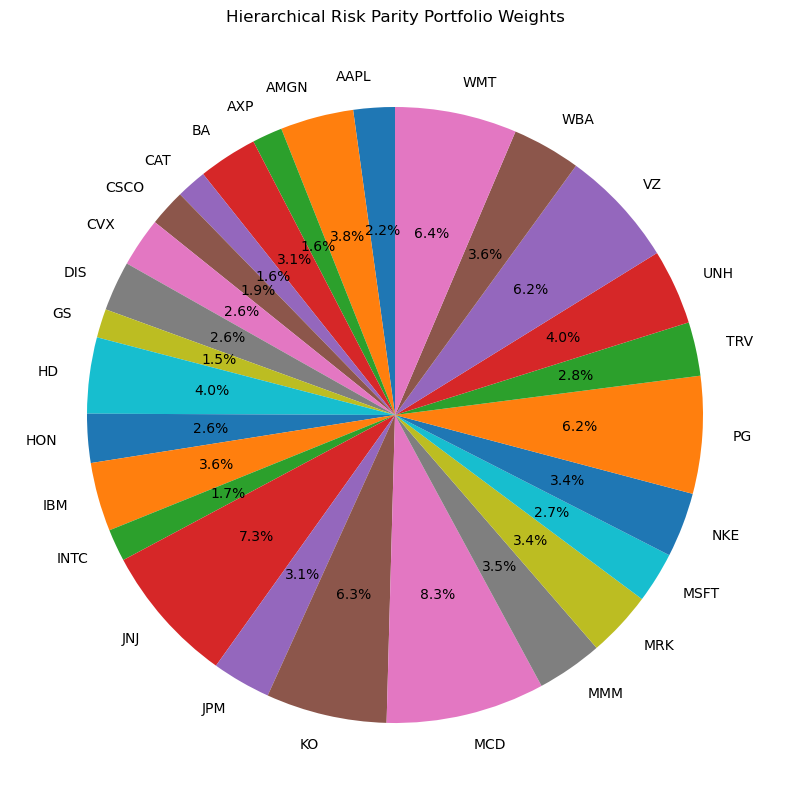

In [123]:
# Visualize the portfolio weights as a pie chart
plt.figure(figsize=(10, 10))
plt.pie(hrp_weights, labels=hrp_weights.index, autopct='%1.1f%%', startangle=90)
plt.title('Hierarchical Risk Parity Portfolio Weights')
plt.show()

The pie chart shows the distribution of weights in the Hierarchical Risk Parity portfolio. The allocation is well- diversified, with weights spread across multiple stocks, ensuring balanced risk contributions.

##### Evaluation: Out-of-Sample Prediction and Sharpe Ratio Calculation

In [124]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['HRP'], index = returns_test.index)

<Axes: title={'center': 'Out Of Sample Results'}, xlabel='Date'>

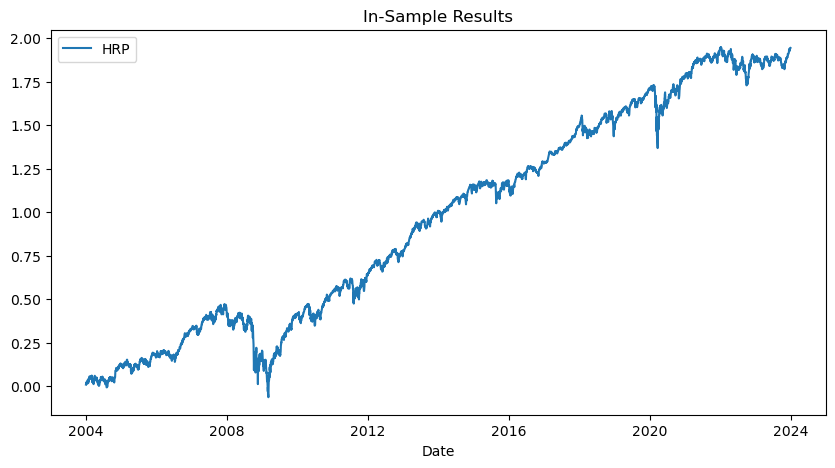

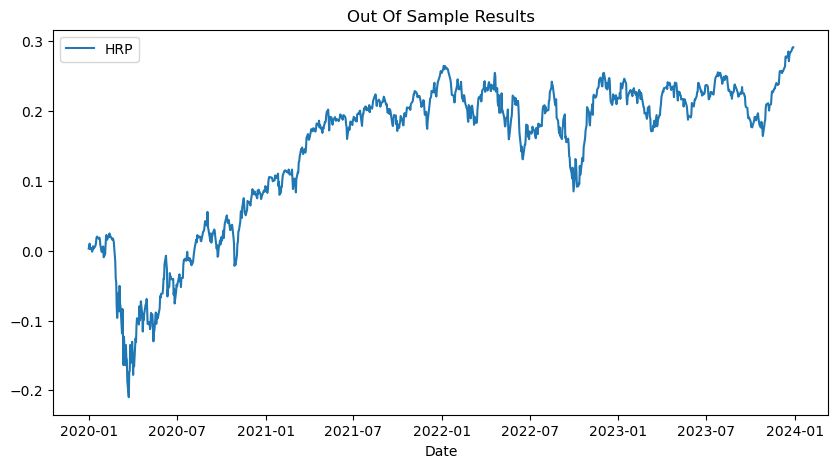

In [125]:

Insample_Result.cumsum().plot(figsize=(10, 5), title ="In-Sample Results")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Out Of Sample Results")

In [126]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
HRP  0.16303     0.596794

In [133]:
# Out of sample Results

stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
HRP   0.157988         0.460912

The HRP portfolio demonstrated strong in-sample performance with a Sharpe ratio of 0.5968, indicating good risk-adjusted returns. Out-of-sample results also showed a solid performance, with a Sharpe ratio of 0.4609. These results highlight the effectiveness of the HRP method in achieving diversified and stable returns.